## Step 1 - Setup

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [36]:
# For reproducibility

SEED = 42
np.random.seed(SEED)

In [37]:
# Utility for report and visualization

def report_metrics(y_true, y_pred, title="Classification Report"):
    print(f"\n{title}")
    print(classification_report(y_true, y_pred, digits=3))

def plot_class_distribution(df, target_col="good"):
    counts = df[target_col].value_counts(normalize=True) * 100
    sns.barplot(x=counts.index, y=counts.values)
    plt.title("Class Distribution (%)")
    plt.xlabel("Class")
    plt.ylabel("Percentage")
    plt.show()

In [38]:
# Load dataset and merge

red = pd.read_csv("winequality-red.csv", sep=",")
white = pd.read_csv("winequality-white.csv", sep=",")

# Add type column
red["type"] = "red"
white["type"] = "white"

# Merge
df = pd.concat([red, white], axis=0).reset_index(drop=True)
df = df.drop(columns=['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'], errors="ignore")

print(f"Shape: {df.shape}")
print(df.columns)
df.head()

Shape: (6497, 13)
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type'],
      dtype='object')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,red


In [39]:
# Binary target
df["good"] = (df["quality"] >= 7).astype(int)

df[["quality", "good"]].head(10)

,quality,good
0,5.0,0
1,5.0,0
2,5.0,0
3,6.0,0
4,5.0,0
5,5.0,0
6,5.0,0
7,7.0,1
8,7.0,1
9,5.0,0


In [40]:
# Data check

print(f"Missing values for colomns: {df.isna().sum()}")

# Duplicate check
print(f"\nDuplicates: {df.duplicated().sum()}")

Missing values for colomns: fixed acidity           4898
volatile acidity        4898
citric acid             4898
residual sugar          4898
chlorides               4898
free sulfur dioxide     4898
total sulfur dioxide    4898
density                 4898
pH                      4898
sulphates               4898
alcohol                 4898
quality                 4898
type                       0
good                       0
dtype: int64

Duplicates: 5137


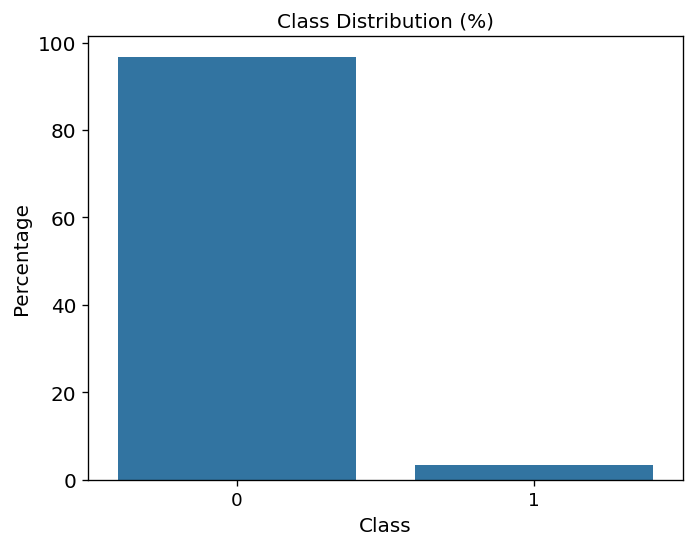

In [41]:
# Class imbalance

plot_class_distribution(df, "good")

# Very unbalanced towards the good

In [42]:
# Define Features and Split

X = df.drop(columns=["quality", "good"])
y = df["good"]

# Train / Valid / Test split 
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

print(f"Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")
print(f"Class distribution: {y_train.value_counts(normalize=True)}")

# We have a lot more bad wines than good ones

Train: (4547, 12), Valid: (975, 12), Test: (975, 12)
Class distribution: good
0    0.966571
1    0.033429
Name: proportion, dtype: float64


## Step 2 - EDA & Preprocessing Pipeline

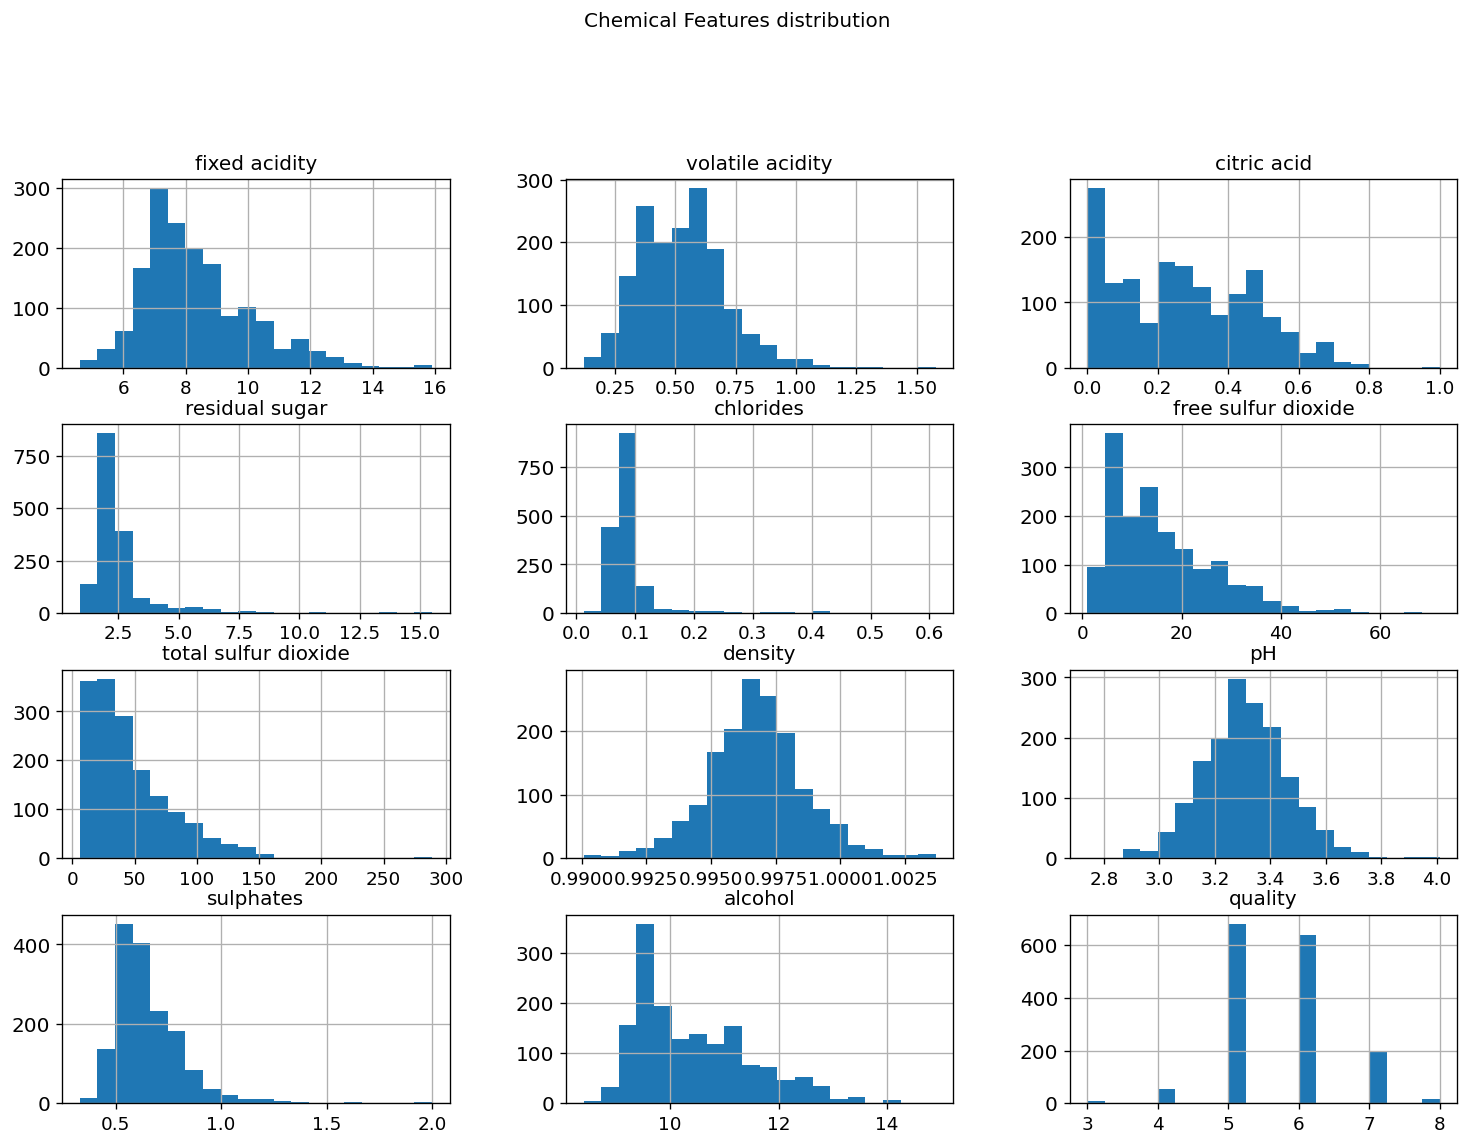

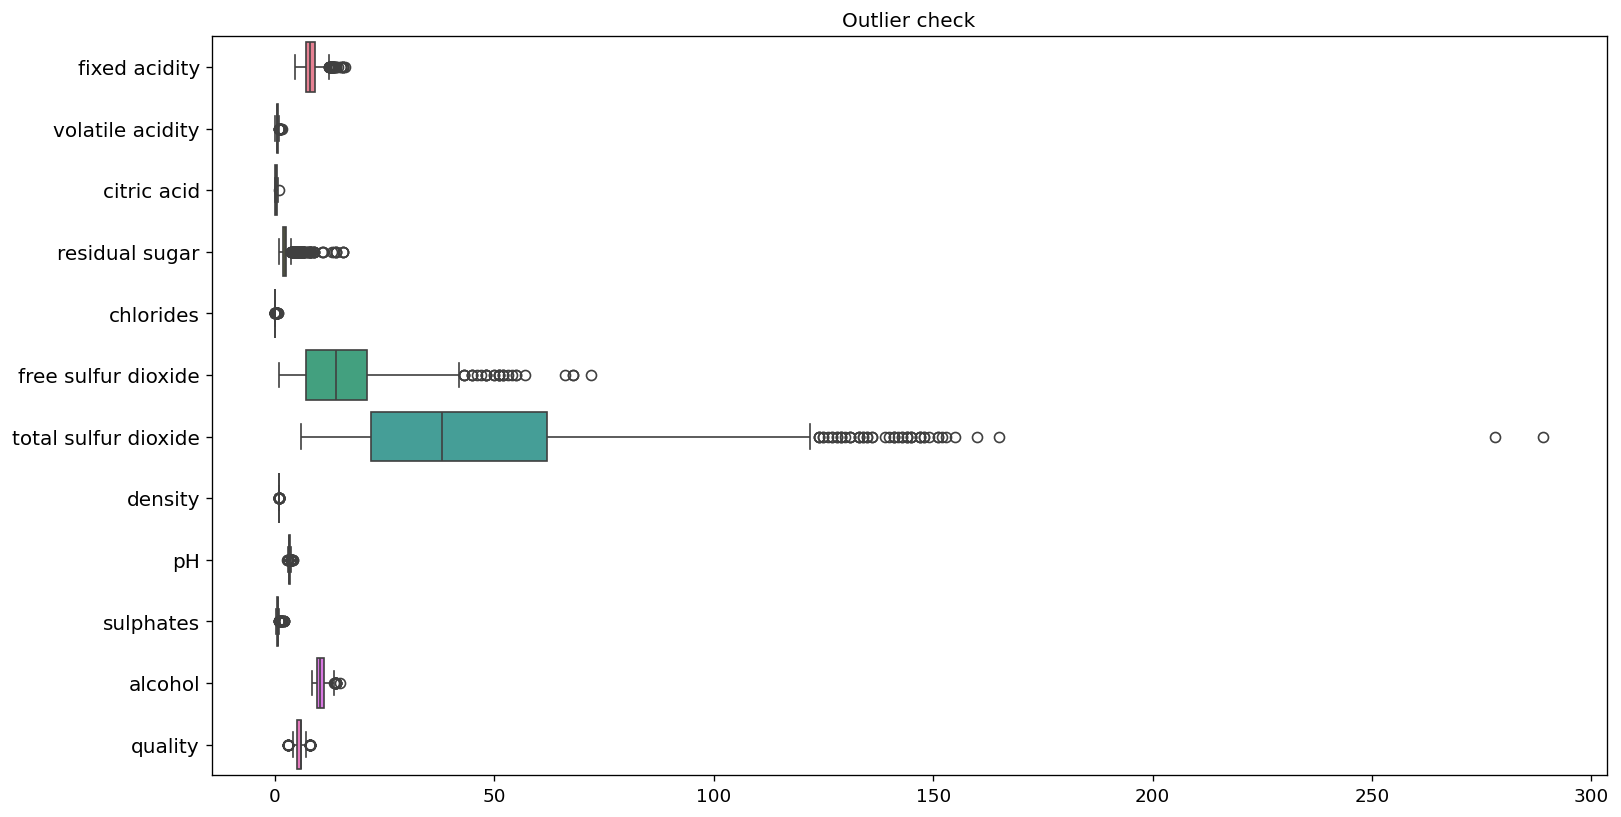

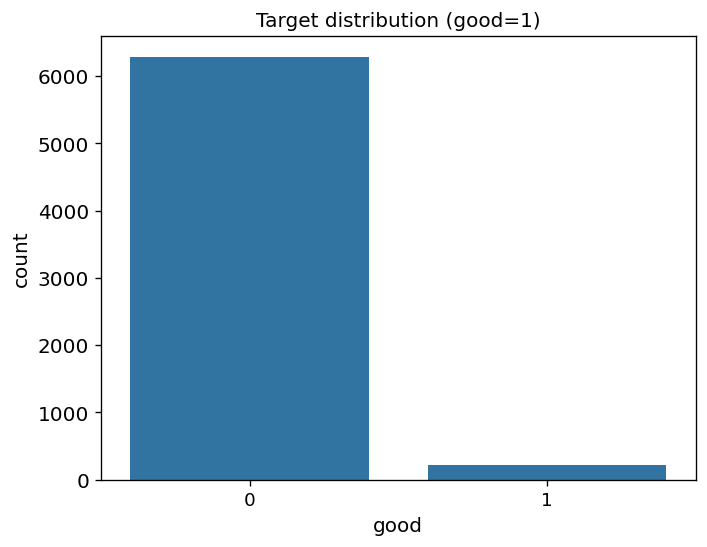

In [43]:
# Feature & Target Distribution

import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numerical features
df.drop(columns=["type", "good"]).hist(bins=20, figsize=(15,10))
plt.suptitle("Chemical Features distribution", y=1.02)
plt.show()

# Boxplot for outlier detection
plt.figure(figsize=(15,8))
sns.boxplot(data=df.drop(columns=["type", "good"]), orient="h")
plt.title("Outlier check")
plt.show()

# Target distribution
sns.countplot(x="good", data=df)
plt.title("Target distribution (good=1)")
plt.show()

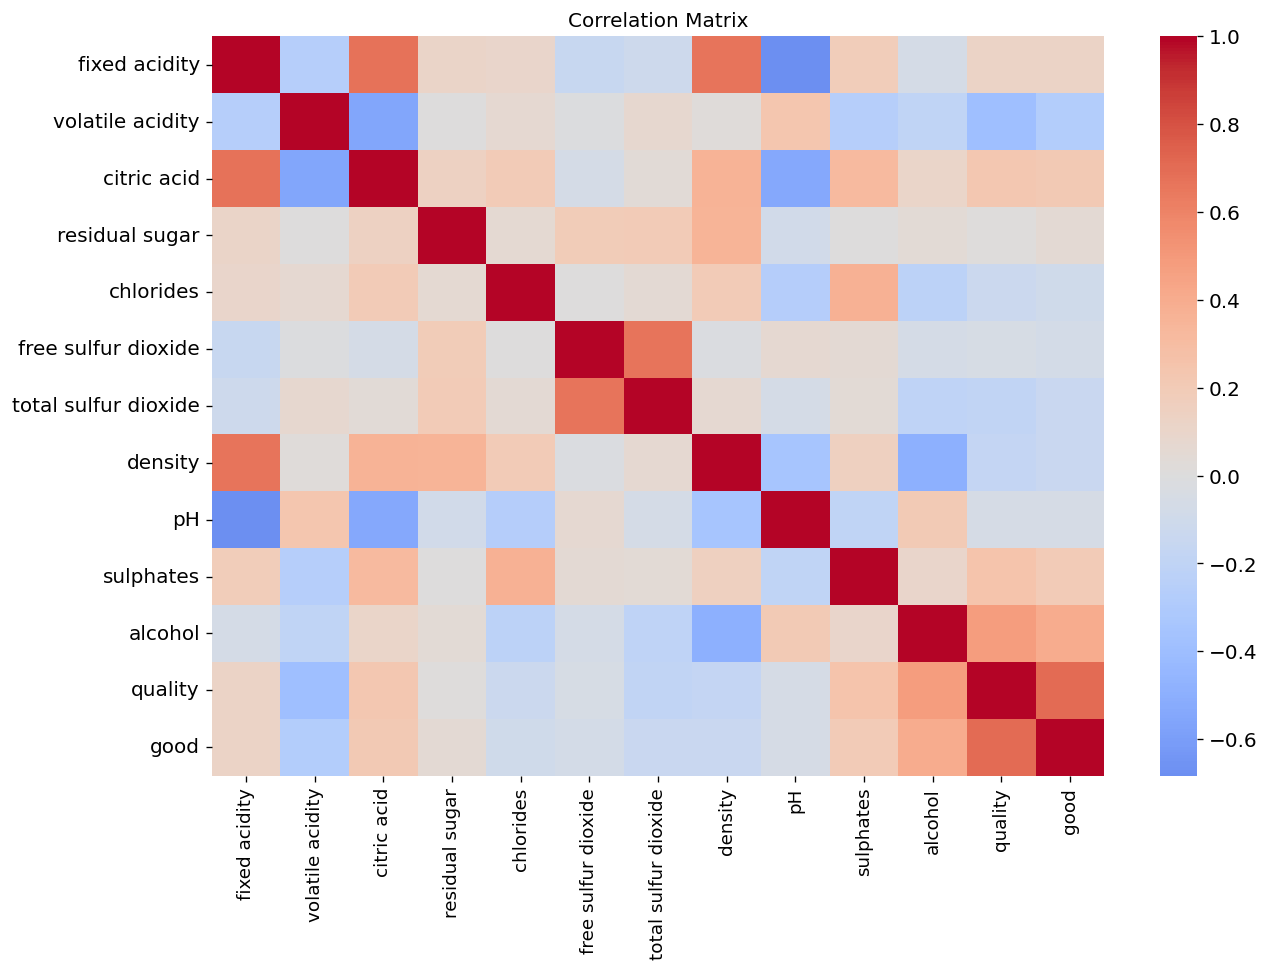

Top 5 correlations with quality:
quality          1.000000
good             0.710196
alcohol          0.476166
sulphates        0.251397
citric acid      0.226373
fixed acidity    0.124052
Name: quality, dtype: float64


In [44]:
# Correlations

plt.figure(figsize=(12,8))
corr = df.drop(columns=["type"]).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

print("Top 5 correlations with quality:")
print(corr["quality"].sort_values(ascending=False).head(6))

In [45]:
# Multicollinearity - first deal with nans and infinites before using variance_inflation_factor

import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# take numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["quality", "good"]]

X_vif = df[num_cols].copy()

# remove inf and Nan
X_vif = X_vif.apply(pd.to_numeric, errors="coerce")
X_vif = X_vif.replace([np.inf, -np.inf], np.nan)

# fill nans with median
X_vif = X_vif.fillna(X_vif.median(numeric_only=True))

# remove constant columns that can cause inf VIF
const_cols = [c for c in X_vif.columns if X_vif[c].nunique(dropna=True) <= 1]
if const_cols:
    print(f"Constant columns removed: {const_cols}")
    X_vif = X_vif.drop(columns=const_cols)

# compute VIF
X_vif_const = add_constant(X_vif, has_constant="add")
vif_vals = []
for i, col in enumerate(X_vif_const.columns):
    if col == "const":
        continue
    vif_vals.append((col, variance_inflation_factor(X_vif_const.values, i)))

vif_df = pd.DataFrame(vif_vals, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)
vif_df

,feature,VIF
0,fixed acidity,6.016605
7,density,5.419014
10,alcohol,3.067772
2,citric acid,3.011917
8,pH,2.873167
6,total sulfur dioxide,2.143623
5,free sulfur dioxide,1.999289
1,volatile acidity,1.791749
3,residual sugar,1.618395
4,chlorides,1.445055


In [46]:
# Preprocessing Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# divide numerical and categorical
numeric_features = df.drop(columns=["quality", "good", "type"]).columns.tolist()
categorical_features = ["type"]

# Transformers
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="if_binary"))
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# dummy step at the moment
full_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor)
])

# fit only on train
full_pipeline.fit(X_train)

# Transform datasets
X_train_prep = full_pipeline.transform(X_train)
X_valid_prep = full_pipeline.transform(X_valid)
X_test_prep = full_pipeline.transform(X_test)

print("Train trasformato:", X_train_prep.shape)
print("Valid trasformato:", X_valid_prep.shape)
print("Test trasformato:", X_test_prep.shape)

Train trasformato: (4547, 12)
Valid trasformato: (975, 12)
Test trasformato: (975, 12)


In [47]:
# For Step 6 - we need to clean feature names that were transformedby the ColumnTransformer

pre = full_pipeline.named_steps["preprocessor"]
feature_names_out = pre.get_feature_names_out()

print(f"Extracted the feature names: \n{feature_names_out}")

# Reconstruct DataFrame with the names extracted - done in step 3 where we create the inputted dataframes


Extracted the feature names: 
['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__residual sugar' 'num__chlorides' 'num__free sulfur dioxide'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__type_white']


## Step 3 - Baseline & Metrics

In [48]:
# Imports

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, roc_curve, auc,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [49]:
# Helper function to evaluate the model

def _get_scores(model, X):
    # Return a continuous score for ROC/PR if available; else None.
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return None


def evaluate_model(name, model, X_valid, y_valid, X_test, y_test, results):
    # predictions (labels)
    y_pred_val = model.predict(X_valid)
    y_pred_test = model.predict(X_test)

    # continuous scores for curves/auc
    y_score_val = _get_scores(model, X_valid)
    y_score_test = _get_scores(model, X_test)

    # always-available metrics
    metrics = {
        "Model": name,
        "Valid_Accuracy": accuracy_score(y_valid, y_pred_val),
        "Valid_Precision": precision_score(y_valid, y_pred_val, zero_division=0),
        "Valid_Recall": recall_score(y_valid, y_pred_val, zero_division=0),
        "Valid_F1": f1_score(y_valid, y_pred_val, zero_division=0),
        "Test_Accuracy": accuracy_score(y_test, y_pred_test),
        "Test_Precision": precision_score(y_test, y_pred_test, zero_division=0),
        "Test_Recall": recall_score(y_test, y_pred_test, zero_division=0),
        "Test_F1": f1_score(y_test, y_pred_test, zero_division=0),
    }

    # AUC only if continuous score
    if y_score_val is not None and y_score_test is not None:
        metrics["Valid_ROC_AUC"] = roc_auc_score(y_valid, y_score_val)
        p_v, r_v, _ = precision_recall_curve(y_valid, y_score_val)
        metrics["Valid_PR_AUC"] = auc(r_v, p_v)

        metrics["Test_ROC_AUC"] = roc_auc_score(y_test, y_score_test)
        p_t, r_t, _ = precision_recall_curve(y_test, y_score_test)
        metrics["Test_PR_AUC"] = auc(r_t, p_t)
    else:
        metrics["Valid_ROC_AUC"] = np.nan
        metrics["Valid_PR_AUC"] = np.nan
        metrics["Test_ROC_AUC"] = np.nan
        metrics["Test_PR_AUC"] = np.nan

    results.append(metrics)

    # confusion matrix (test)
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name} (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Curves only if we have the scores
    if y_score_test is not None:
        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_score_test)
        roc_auc = roc_auc_score(y_test, y_score_test)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.show()

        # PR
        precision, recall, _ = precision_recall_curve(y_test, y_score_test)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve - {name}")
        plt.legend()
        plt.show()

    return results


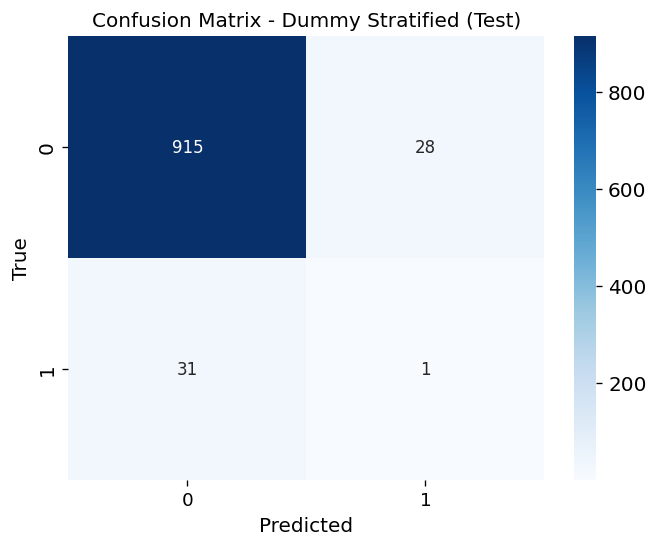

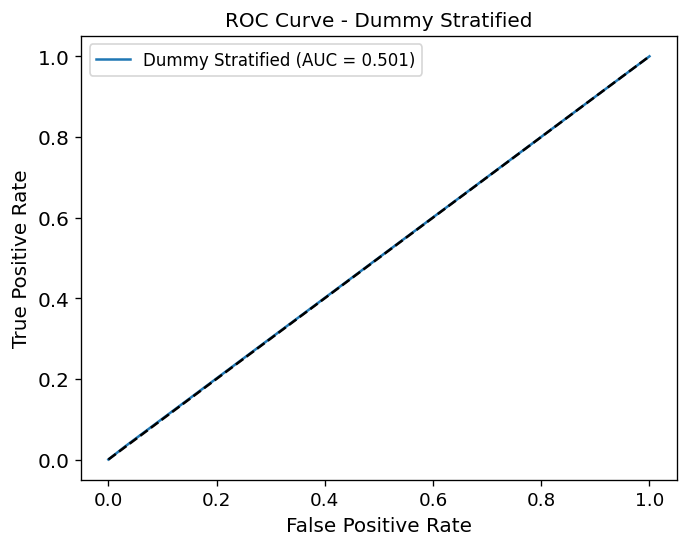

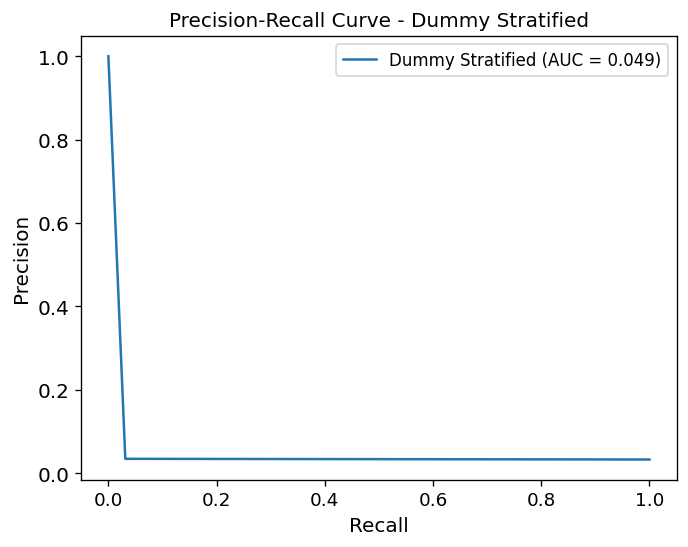

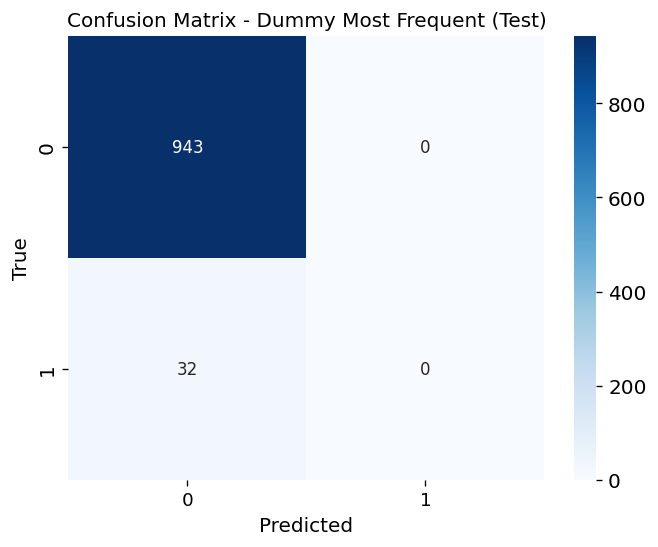

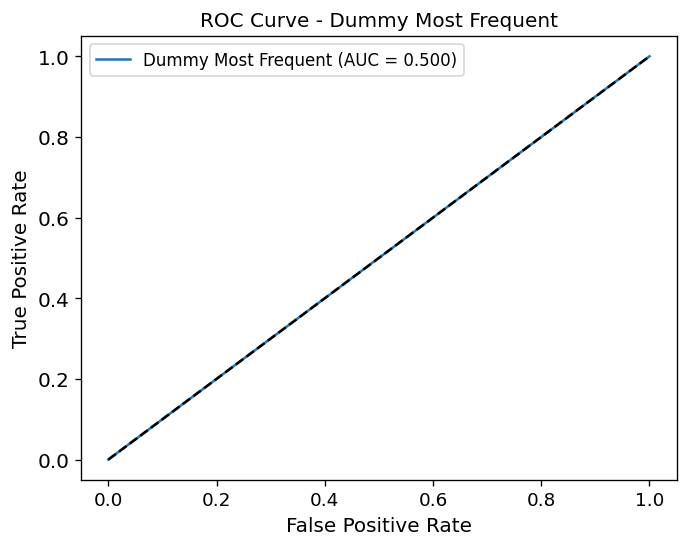

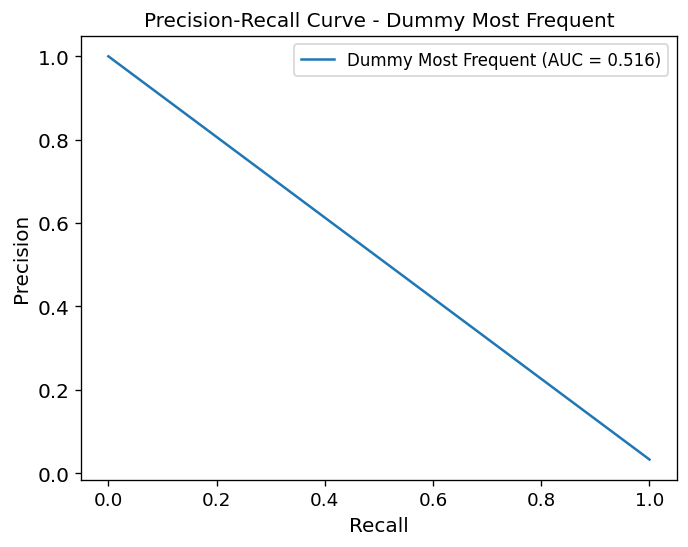

In [50]:
results = []

# Dummy - stratified
dummy_strat = DummyClassifier(strategy="stratified", random_state=SEED)
dummy_strat.fit(X_train_prep, y_train)
results = evaluate_model("Dummy Stratified", dummy_strat, X_valid_prep, y_valid, X_test_prep, y_test, results)

# Dummy - most frequent
dummy_freq = DummyClassifier(strategy="most_frequent")
dummy_freq.fit(X_train_prep, y_train)
results = evaluate_model("Dummy Most Frequent", dummy_freq, X_valid_prep, y_valid, X_test_prep, y_test, results)

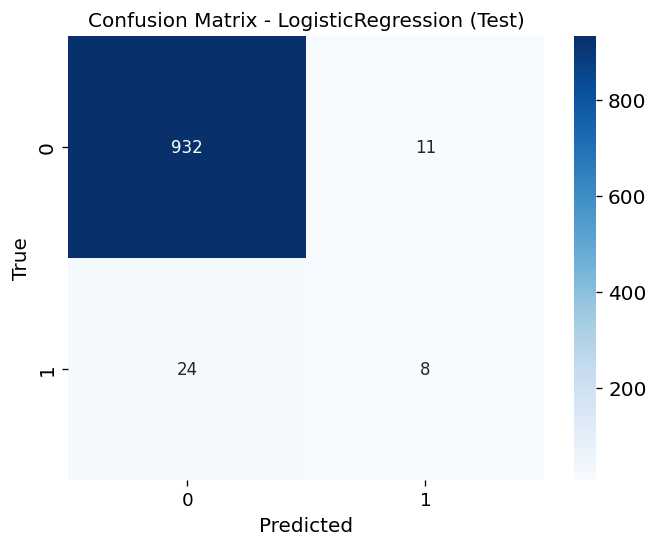

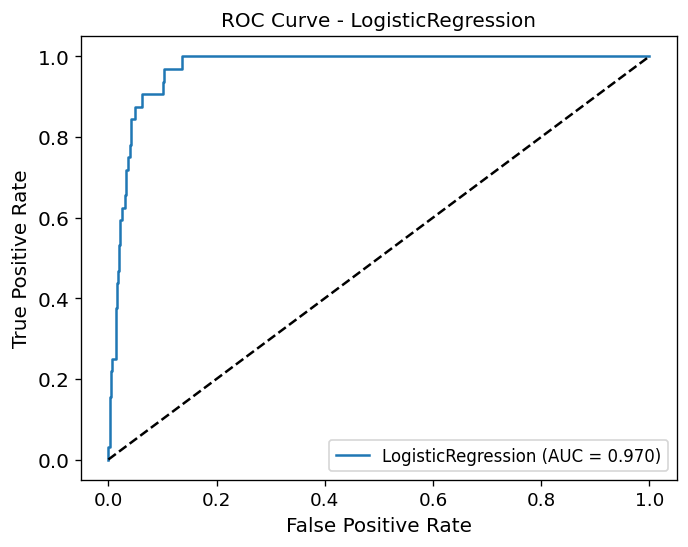

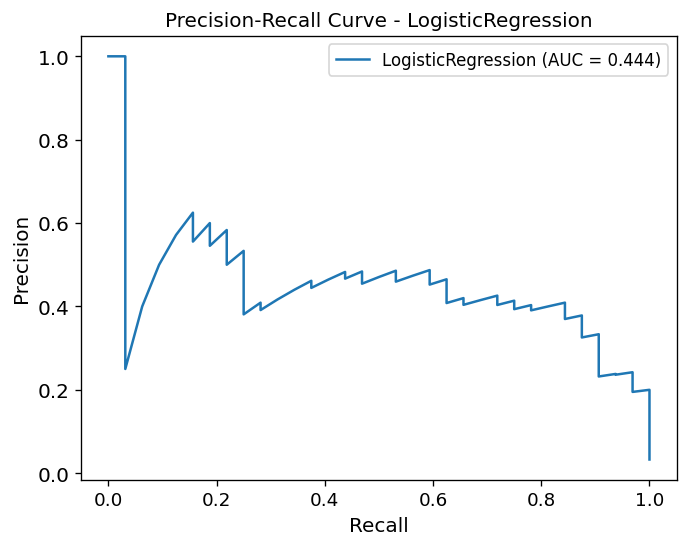

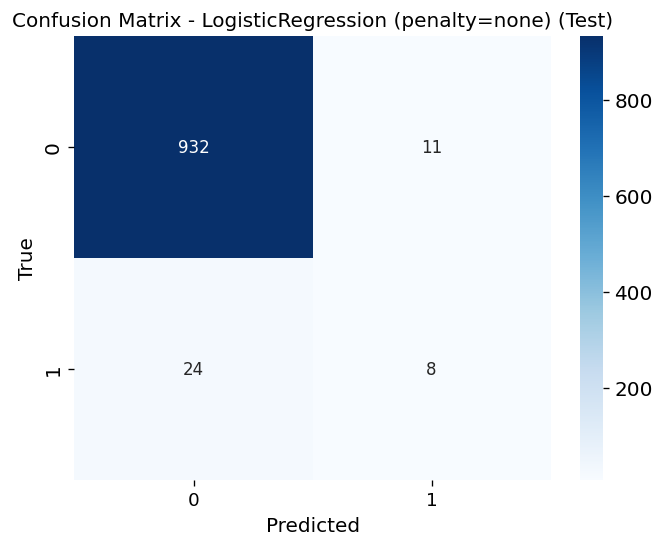

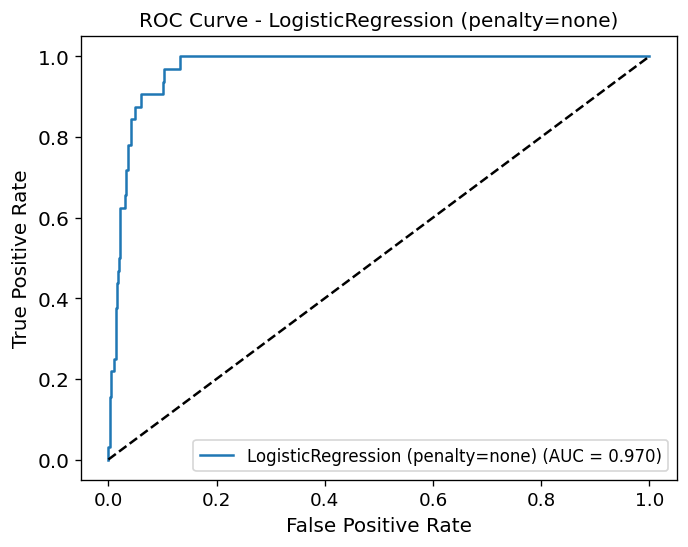

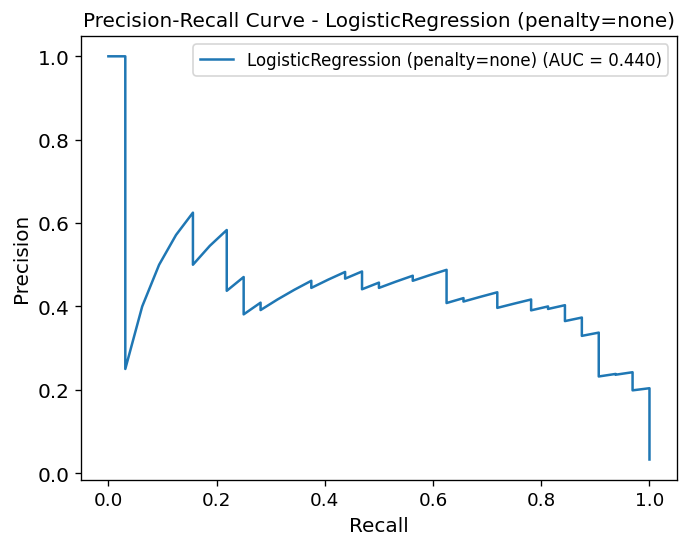

In [51]:
# Logistic Regression - Baseline
from sklearn.impute import SimpleImputer

# Attention to Nans, if log regression detects nans it won't work - from now on going to use these
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_prep)
X_valid_imp = imputer.transform(X_valid_prep)
X_test_imp  = imputer.transform(X_test_prep)

# default log regression
logreg = LogisticRegression(max_iter=500, solver="liblinear")
logreg.fit(X_train_imp, y_train)
results = evaluate_model("LogisticRegression", logreg, X_valid_imp, y_valid, X_test_imp, y_test, results)

# no regularization log regression
logreg_no_reg = LogisticRegression(max_iter=500, solver="lbfgs", penalty=None)
logreg_no_reg.fit(X_train_imp, y_train)
results = evaluate_model("LogisticRegression (penalty=none)", logreg_no_reg, X_valid_imp, y_valid, X_test_imp, y_test, results)

In [52]:
results_df = pd.DataFrame(results)
results_df = results_df.round(3)
results_df

,Model,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Valid_ROC_AUC,Valid_PR_AUC,Test_ROC_AUC,Test_PR_AUC
0,Dummy Stratified,0.943,0.103,0.091,0.097,0.939,0.034,0.031,0.033,0.532,0.113,0.501,0.049
1,Dummy Most Frequent,0.966,0.000,0.000,0.000,0.967,0.000,0.000,0.000,0.500,0.517,0.500,0.516
2,LogisticRegression,0.970,0.611,0.333,0.431,0.964,0.421,0.250,0.314,0.972,0.473,0.970,0.444
3,LogisticRegression (penalty=none),0.970,0.611,0.333,0.431,0.964,0.421,0.250,0.314,0.971,0.470,0.970,0.440


In [53]:
# Reconstruct dataframes with the extracted feature names in Step 2 for Step 6

X_train_imp_df = pd.DataFrame(X_train_imp, columns=feature_names_out, index=X_train.index)
X_valid_imp_df = pd.DataFrame(X_valid_imp, columns=feature_names_out, index=X_valid.index)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=feature_names_out, index=X_test.index)

print("Reconstructed successfully!")

display(X_train_imp_df.head(5))
display(X_valid_imp_df.head(5))
display(X_test_imp_df.head(5))

Reconstructed successfully!


,num__fixed acidity,num__volatile acidity,num__citric acid,num__residual sugar,num__chlorides,num__free sulfur dioxide,num__total sulfur dioxide,num__density,num__pH,num__sulphates,num__alcohol,cat__type_white
4732,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
3260,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
5313,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
6486,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
1689,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0


,num__fixed acidity,num__volatile acidity,num__citric acid,num__residual sugar,num__chlorides,num__free sulfur dioxide,num__total sulfur dioxide,num__density,num__pH,num__sulphates,num__alcohol,cat__type_white
3210,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
2892,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
3489,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
3309,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
4394,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0


,num__fixed acidity,num__volatile acidity,num__citric acid,num__residual sugar,num__chlorides,num__free sulfur dioxide,num__total sulfur dioxide,num__density,num__pH,num__sulphates,num__alcohol,cat__type_white
4222,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
5466,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
3395,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
6376,-0.236415,-0.044245,-0.052431,-0.239587,-0.175124,-0.264304,-0.262852,-0.019126,-0.018006,-0.220911,-0.301611,1.0
246,-0.696034,0.829082,-1.048611,-0.450314,-0.289909,0.022586,0.122664,0.048866,0.436721,-0.817020,-0.855444,0.0


## Step 4 - Handle Imbalance & Threshold tuning

In [54]:
# Imports

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

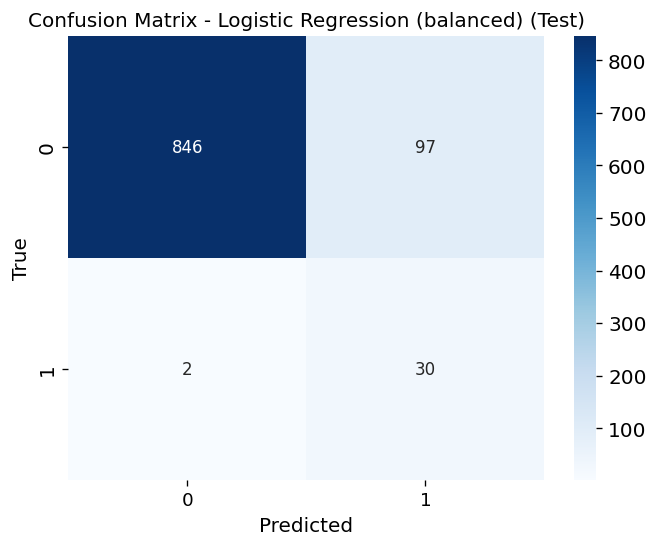

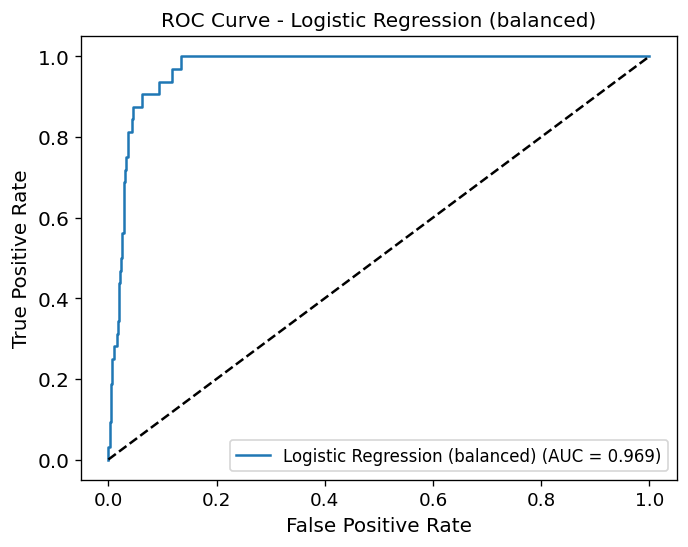

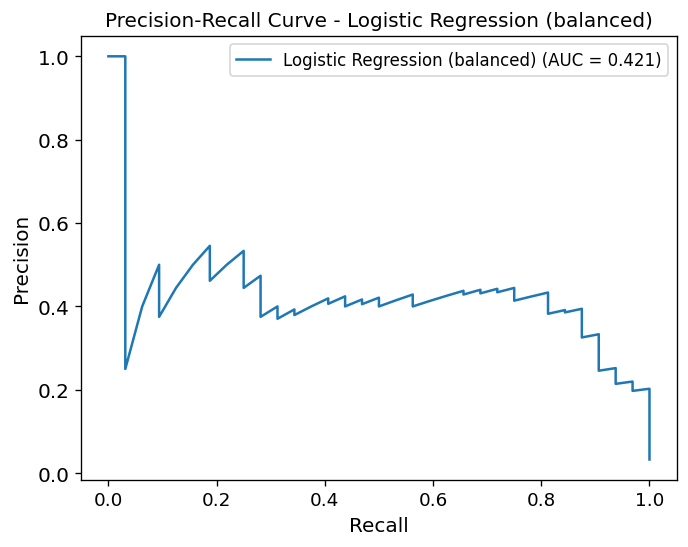

In [55]:
# Here we try Logistic Regression with class_weight

results = []

logreg_bal = LogisticRegression(max_iter=500, solver="liblinear", class_weight="balanced")
logreg_bal.fit(X_train_imp, y_train)

results = evaluate_model("Logistic Regression (balanced)", logreg_bal, X_valid_imp, y_valid, X_test_imp, y_test, results)

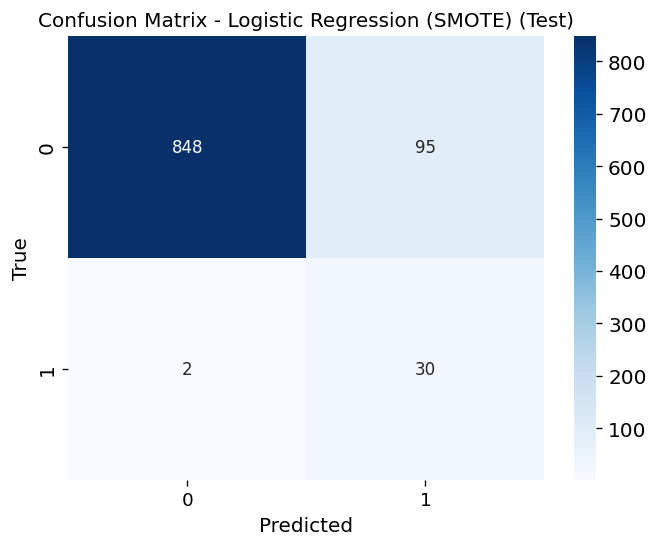

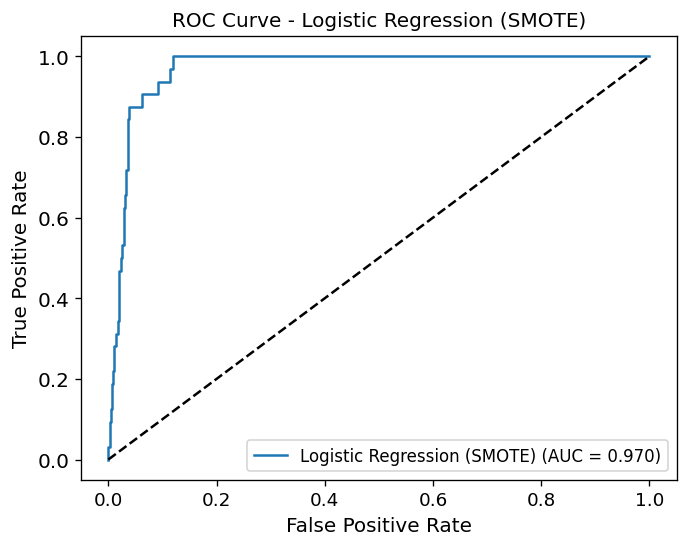

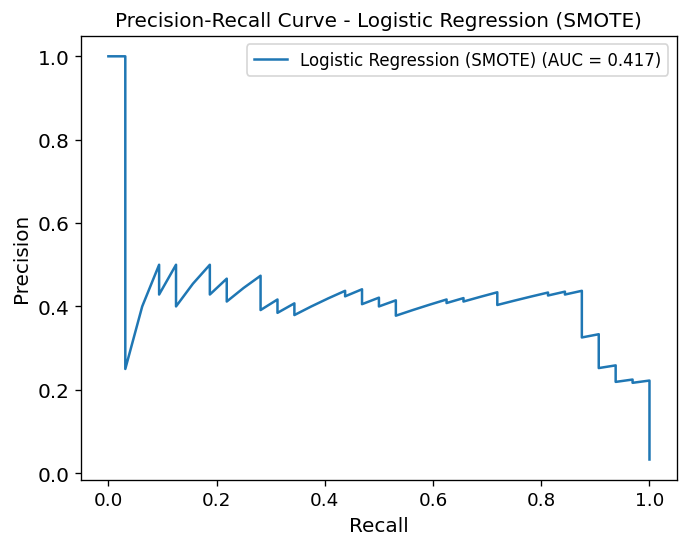

In [56]:
# Now let's try Logistic Regression with SMOTE, applied only on train

smote = SMOTE(random_state=SEED)

logreg_smote = ImbPipeline(steps=[
    ("smote", smote),
    ("model", LogisticRegression(max_iter=500, solver="liblinear"))
])

logreg_smote.fit(X_train_imp, y_train)
results = evaluate_model("Logistic Regression (SMOTE)", logreg_smote, X_valid_imp, y_valid, X_test_imp, y_test, results)

In [57]:
# Compare class_weight and SMOTE approaches

results_df = pd.DataFrame(results).round(3)
results_df

,Model,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Valid_ROC_AUC,Valid_PR_AUC,Test_ROC_AUC,Test_PR_AUC
0,Logistic Regression (balanced),0.907,0.254,0.909,0.397,0.898,0.236,0.938,0.377,0.972,0.496,0.969,0.421
1,Logistic Regression (SMOTE),0.907,0.246,0.848,0.381,0.901,0.240,0.938,0.382,0.969,0.478,0.970,0.417


Best threshold for F1: 0.883, F1=0.588


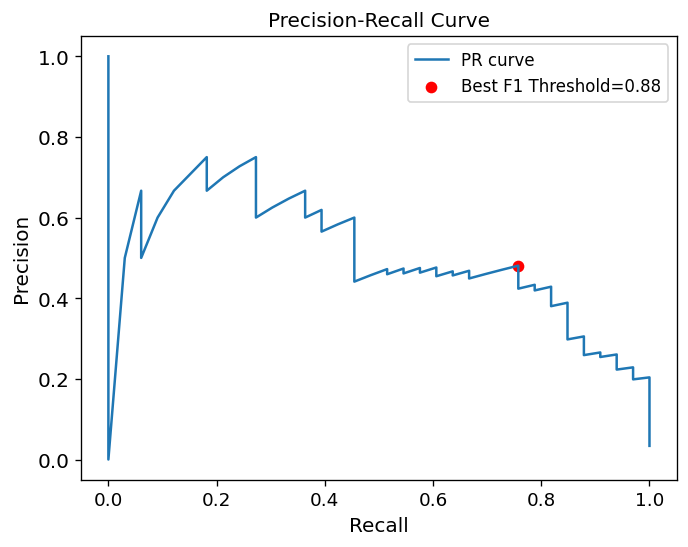

In [58]:
# For Logistic Regression balanced, we try Threshold Tuning
import numpy as np

y_scores = logreg_bal.predict_proba(X_valid_imp)[:,1]
prec, rec, thr = precision_recall_curve(y_valid, y_scores)

# Compute F1 for every threshold
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_thr = thr[best_idx]

print(f"Best threshold for F1: {best_thr:.3f}, F1={f1_scores[best_idx]:.3f}")

# Plot Precision-Recall with F1
plt.plot(rec, prec, label="PR curve")
plt.scatter(rec[best_idx], prec[best_idx], color="red", label=f"Best F1 Threshold={best_thr:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

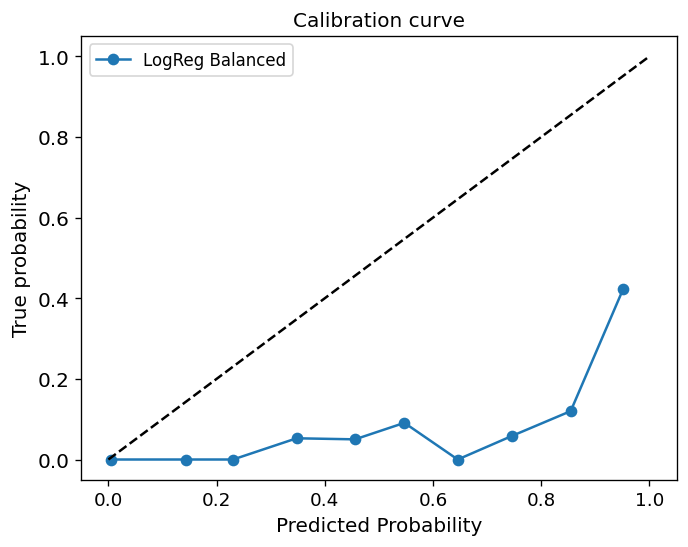

Brier score for LogReg Balanced, Test: 0.076


In [59]:
# We try to calibrate the balanced model
y_proba_test = logreg_bal.predict_proba(X_test_imp)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_proba_test, n_bins=10)

plt.plot(prob_pred, prob_true, marker="o", label="LogReg Balanced")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("Predicted Probability")
plt.ylabel("True probability")
plt.title("Calibration curve")
plt.legend()
plt.show()

# Brier score
brier = brier_score_loss(y_test, y_proba_test)
print(f"Brier score for LogReg Balanced, Test: {brier:.3f}")

## Step 5 - Ensemble Models and Hyperparameter Tuning

In [60]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
import numpy as np

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_

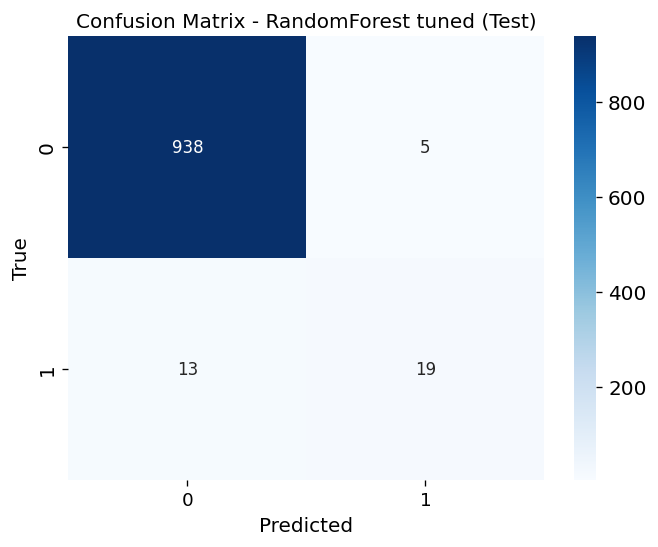

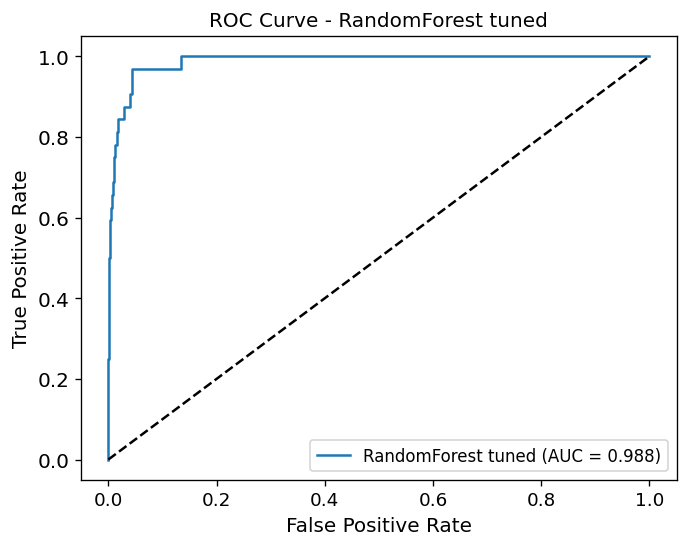

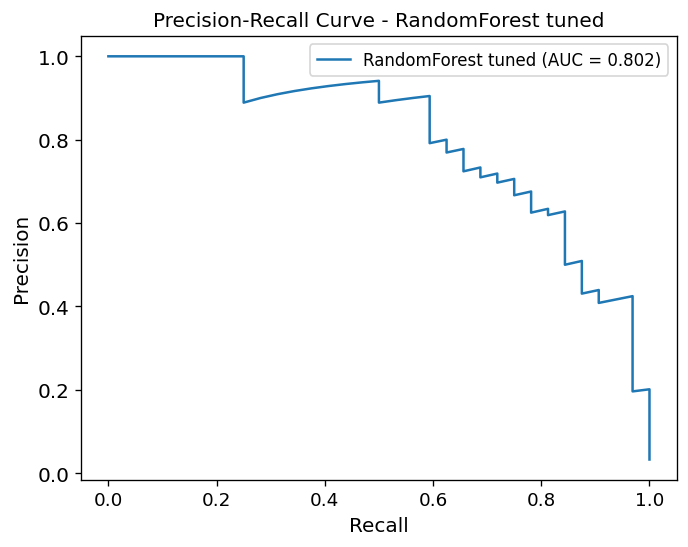

In [61]:
# Here I create a RandomForest with Hyperparameter Tuning

rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)

rf_params = {
    "n_estimators": [100,200,300,500],
    "max_depth": [None,5,10,20],
    "min_samples_split": [2,5,10],
    "min_samples_leaf": [1,2,4],
    "class_weight": [None,"balanced"]
}

rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=15, cv=3, scoring="roc_auc", random_state=SEED, n_jobs=-1, verbose=2
)
rf_search.fit(X_train_imp, y_train)

best_rf = rf_search.best_estimator_
results = evaluate_model("RandomForest tuned", best_rf, X_valid_imp, y_valid, X_test_imp, y_test, results)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END 

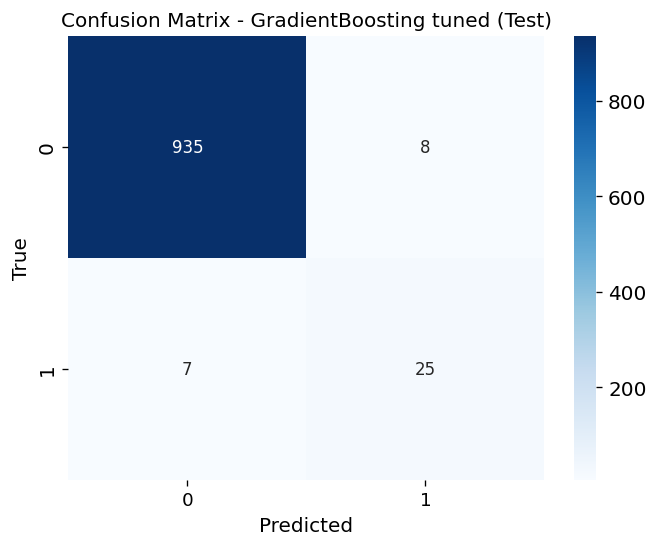

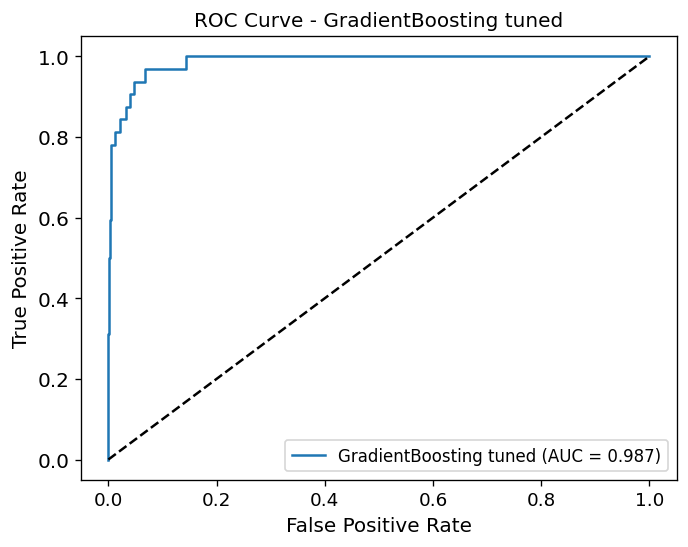

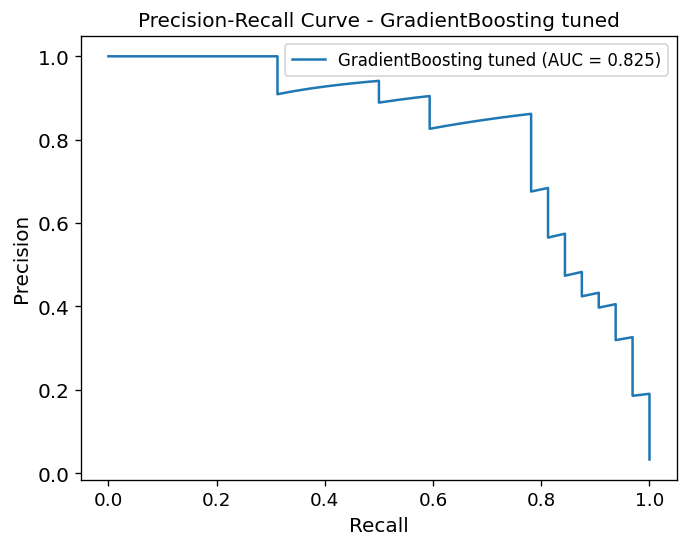

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=400, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=400, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=400, scale_pos_weight=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=400, scale_pos_weight=10, subsample=1.0; total time= 

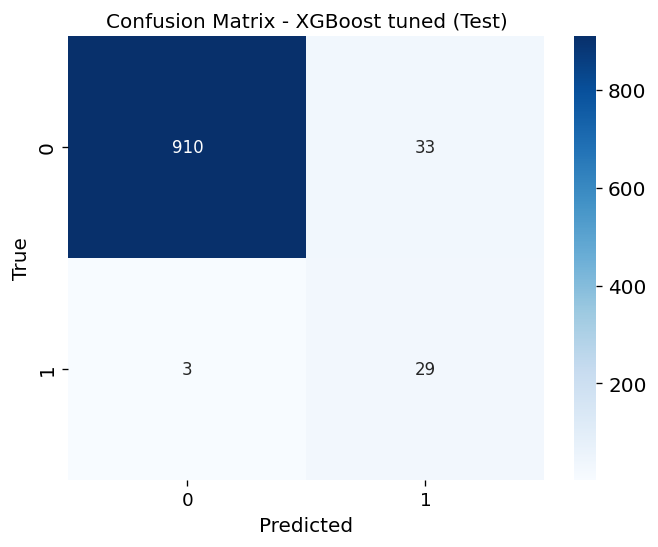

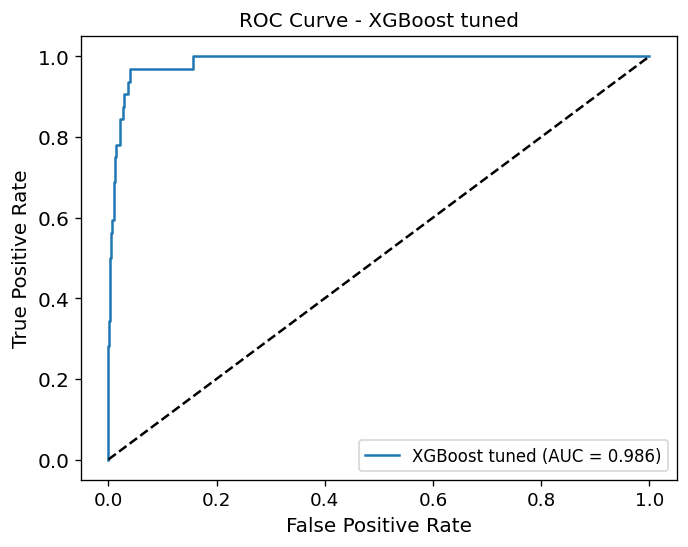

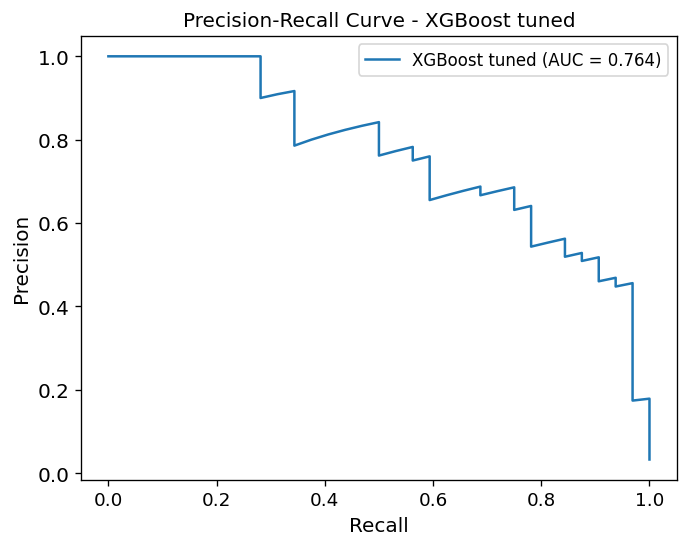

In [62]:
# Gradient Boosting and XGBoost 
from xgboost import XGBClassifier

# First let's go with gradient Boosting
gb = GradientBoostingClassifier(random_state=SEED)
gb_params = {
    "n_estimators": [100,200,300],
    "max_depth": [3,5],
    "learning_rate": [0.05,0.1,0.2],
    "subsample": [0.8,1.0]
}

gb_search = RandomizedSearchCV(
    gb, gb_params, n_iter=10, cv=3, scoring="roc_auc", random_state=SEED, n_jobs=-1, verbose=2
)
gb_search.fit(X_train_imp, y_train)

best_gb = gb_search.best_estimator_
results = evaluate_model("GradientBoosting tuned", best_gb, X_valid_imp, y_valid, X_test_imp, y_test, results)

# Then try also XGBoost
xgb = XGBClassifier(random_state=SEED, eval_metric="logloss", use_label_encoder=False, n_jobs=-1)
xgb_params = {
    "n_estimators": [200,400,600],
    "max_depth": [3,5,7],
    "learning_rate": [0.01,0.05,0.1],
    "subsample": [0.8,1.0],
    "colsample_bytree": [0.8,1.0],
    "scale_pos_weight": [1,5,10] # handles unbalance
}

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=12, cv=3, scoring="roc_auc", random_state=SEED, n_jobs=-1, verbose=2
)
xgb_search.fit(X_train_imp, y_train)

best_xgb = xgb_search.best_estimator_
results = evaluate_model("XGBoost tuned", best_xgb, X_valid_imp, y_valid, X_test_imp, y_test, results)

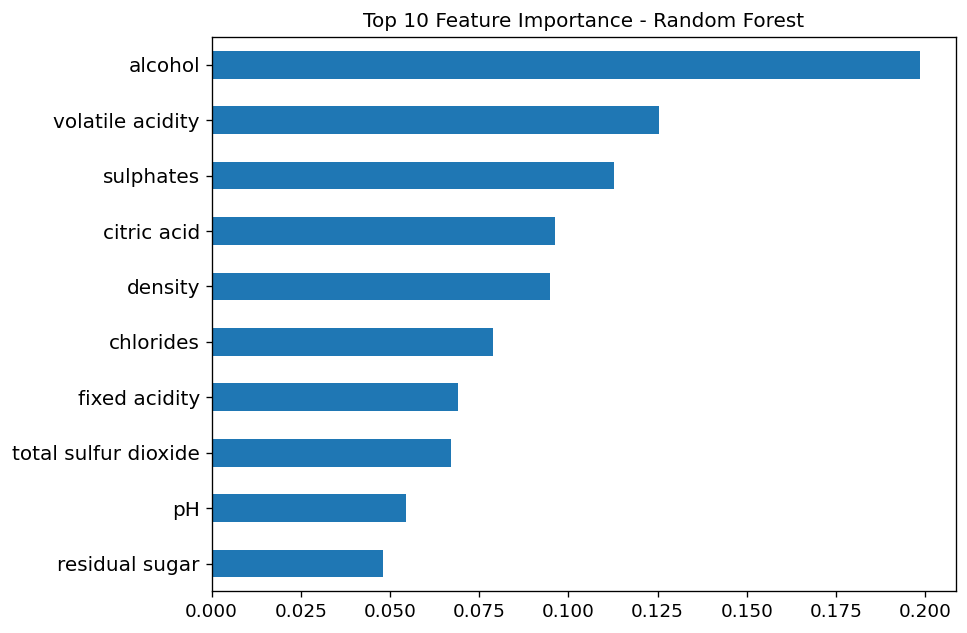

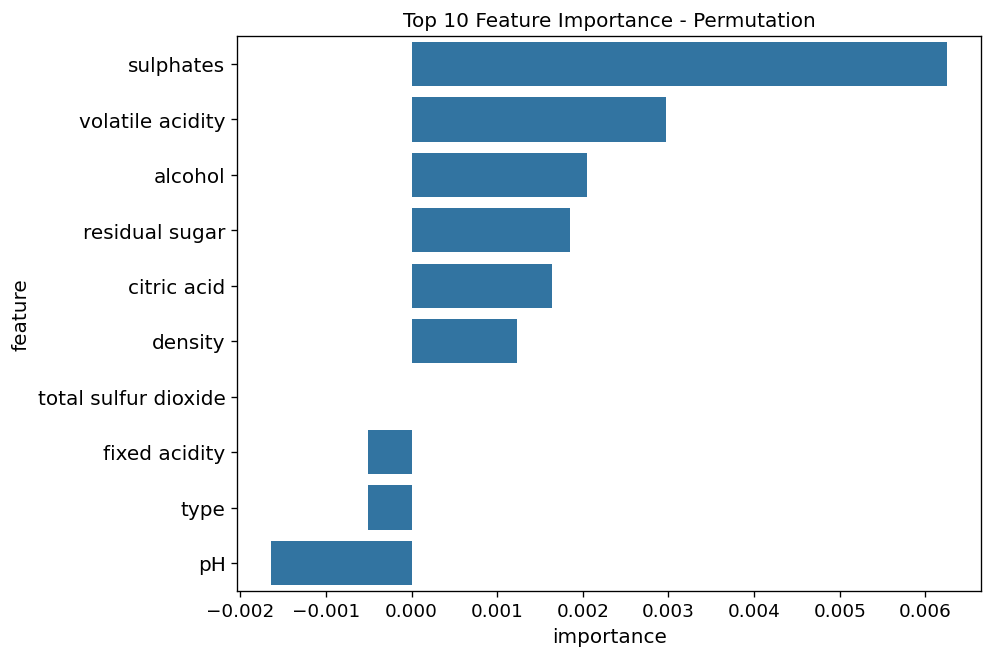

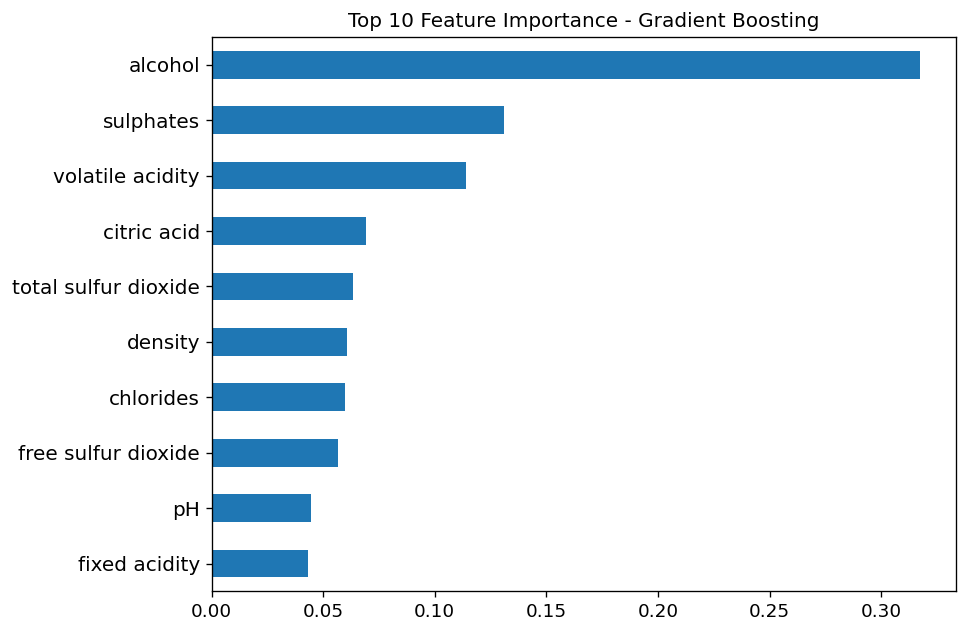

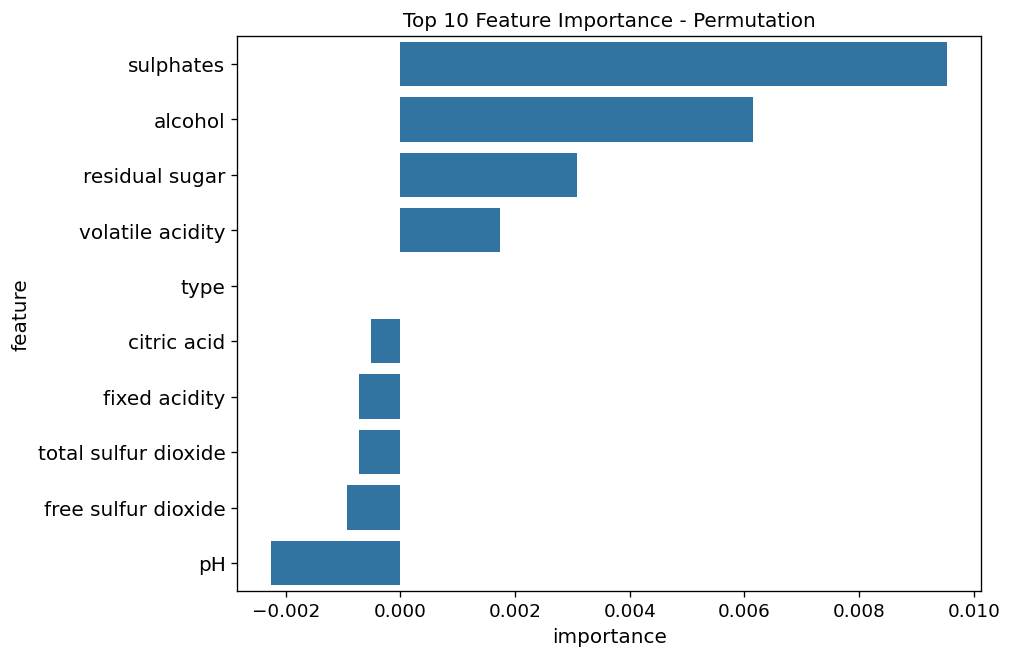

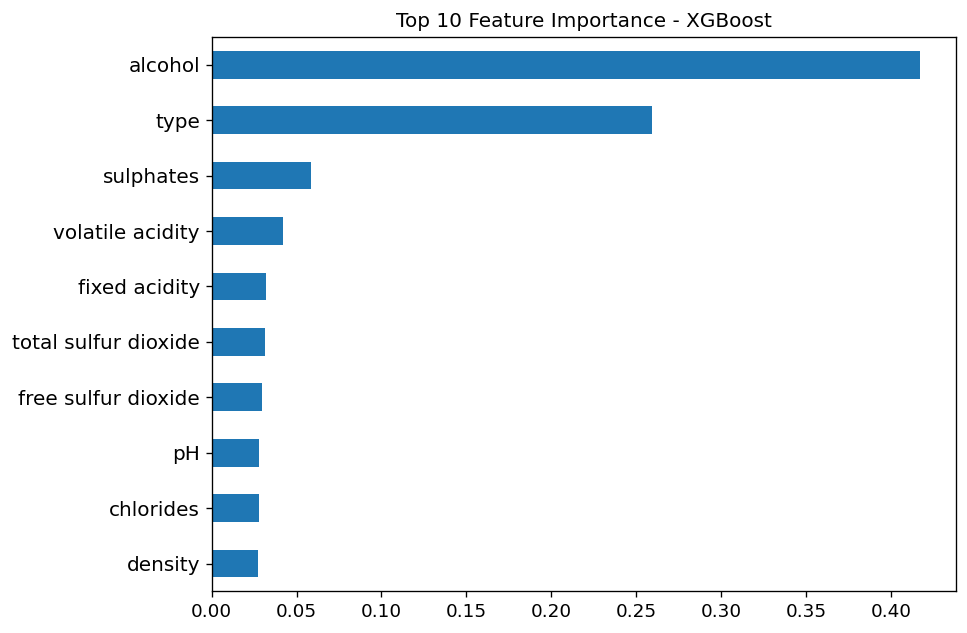

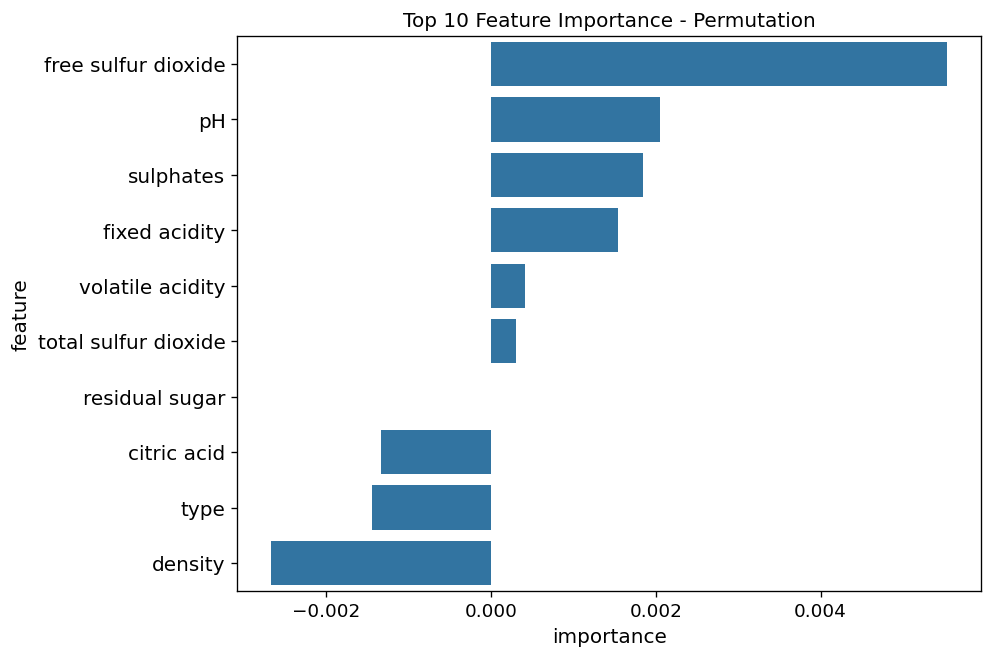

,feature,coef
10,alcohol,1.294420
9,sulphates,0.696162
0,fixed acidity,0.555282
3,residual sugar,0.231738
5,free sulfur dioxide,0.138335
8,pH,-0.165368
2,citric acid,-0.217607
7,density,-0.360907
6,total sulfur dioxide,-0.462748
4,chlorides,-0.485813


In [63]:
# Check Feature Important and compare with LogReg

# Random Forest importance with Gini criterion
importances = best_rf.feature_importances_
feat_names = list(X_train.columns)
forest_importances = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
forest_importances.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importance - Random Forest")
plt.gca().invert_yaxis()
plt.show()

# Permutation importance
perm = permutation_importance(best_rf, X_valid_imp, y_valid, n_repeats=10, random_state=SEED)
perm_df = pd.DataFrame({"feature": feat_names, "importance": perm.importances_mean}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=perm_df.head(10), x="importance", y="feature")
plt.title("Top 10 Feature Importance - Permutation")
plt.show()

# Gradient Boosting importance
importances = best_gb.feature_importances_
feat_names = list(X_train.columns)
gradient_importances = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
gradient_importances.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importance - Gradient Boosting")
plt.gca().invert_yaxis()
plt.show()

# Permutation importance
perm = permutation_importance(best_gb, X_valid_imp, y_valid, n_repeats=10, random_state=SEED)
perm_df = pd.DataFrame({"feature": feat_names, "importance": perm.importances_mean}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=perm_df.head(10), x="importance", y="feature")
plt.title("Top 10 Feature Importance - Permutation")
plt.show()

# XGBoost importance
importances = best_xgb.feature_importances_
feat_names = list(X_train.columns)
xgb_importances = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
xgb_importances.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importance - XGBoost")
plt.gca().invert_yaxis()
plt.show()

# Permutation importance
perm = permutation_importance(best_xgb, X_valid_imp, y_valid, n_repeats=10, random_state=SEED)
perm_df = pd.DataFrame({"feature": feat_names, "importance": perm.importances_mean}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=perm_df.head(10), x="importance", y="feature")
plt.title("Top 10 Feature Importance - Permutation")
plt.show()

# Compare with LogReg coefficients
logreg = LogisticRegression(max_iter=500, solver="liblinear", class_weight="balanced")
logreg.fit(X_train_imp, y_train)
coef_df = pd.DataFrame({"feature": feat_names, "coef": logreg.coef_[0]}).sort_values("coef", ascending=False)
coef_df.head(10)

In [64]:
# Table with best models

results_df = pd.DataFrame(results).round(3)
results_df.sort_values("Valid_ROC_AUC", ascending=False).head(5)

,Model,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_F1,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Valid_ROC_AUC,Valid_PR_AUC,Test_ROC_AUC,Test_PR_AUC
3,GradientBoosting tuned,0.974,0.700,0.424,0.528,0.985,0.758,0.781,0.769,0.981,0.658,0.987,0.825
4,XGBoost tuned,0.963,0.471,0.727,0.571,0.963,0.468,0.906,0.617,0.980,0.655,0.986,0.764
2,RandomForest tuned,0.972,0.667,0.364,0.471,0.982,0.792,0.594,0.679,0.977,0.649,0.988,0.802
0,Logistic Regression (balanced),0.907,0.254,0.909,0.397,0.898,0.236,0.938,0.377,0.972,0.496,0.969,0.421
1,Logistic Regression (SMOTE),0.907,0.246,0.848,0.381,0.901,0.240,0.938,0.382,0.969,0.478,0.970,0.417


## Step 6 — Explainability and Final Output

[MESSAGE] Adapt dimensions: X has 12 cols, SHAP has 2 cols -> use the first 2.

[PLOT] SHAP plot for Random Forest


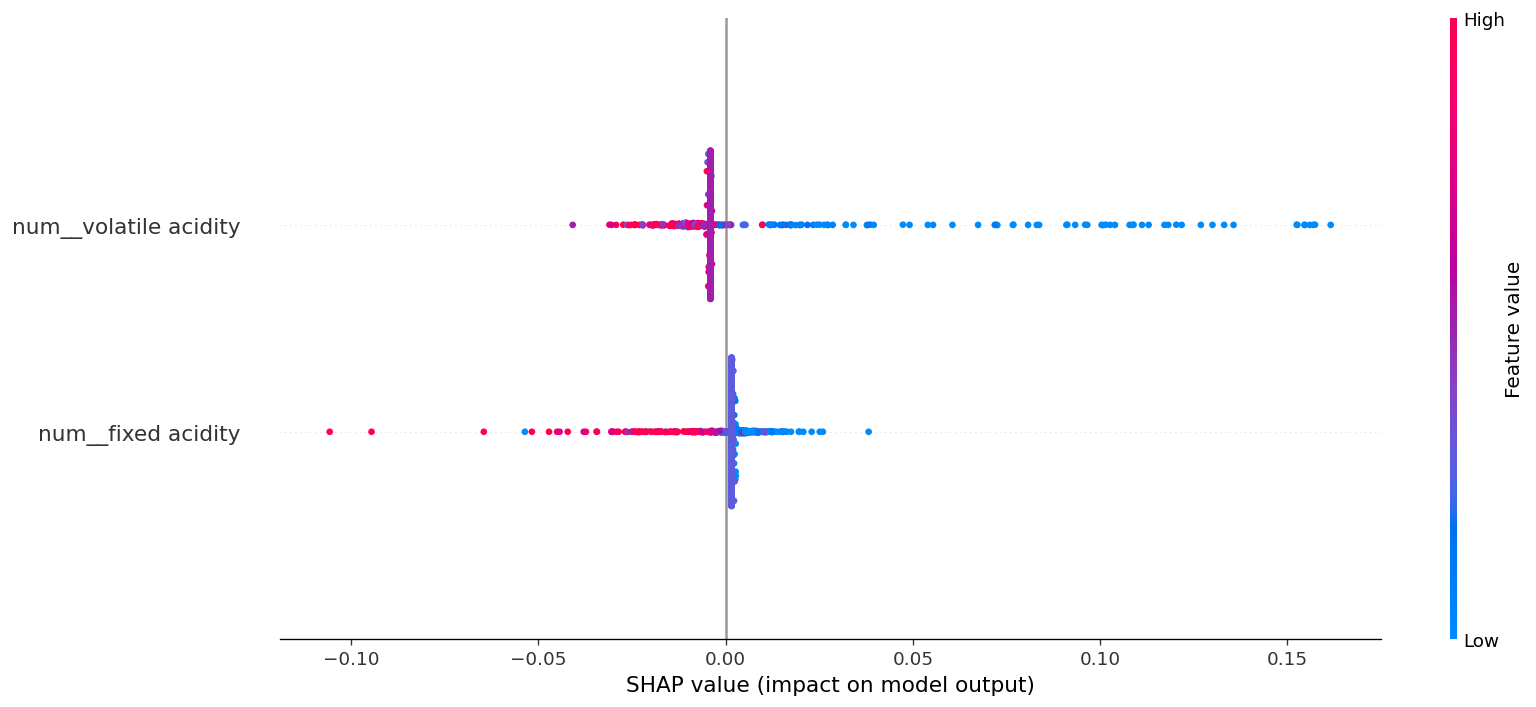


[PLOT] SHAP plot for XGBoost


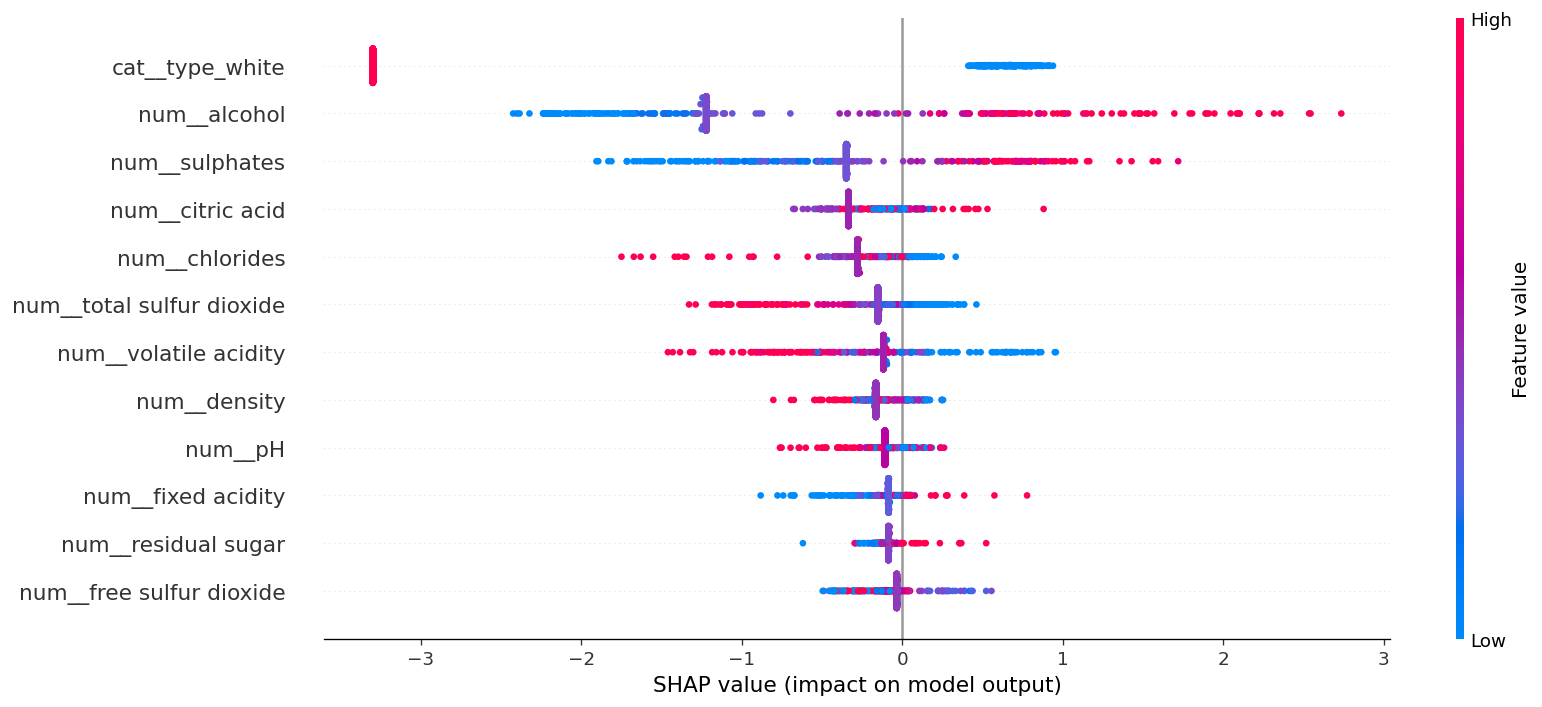


PDP for Random Forest


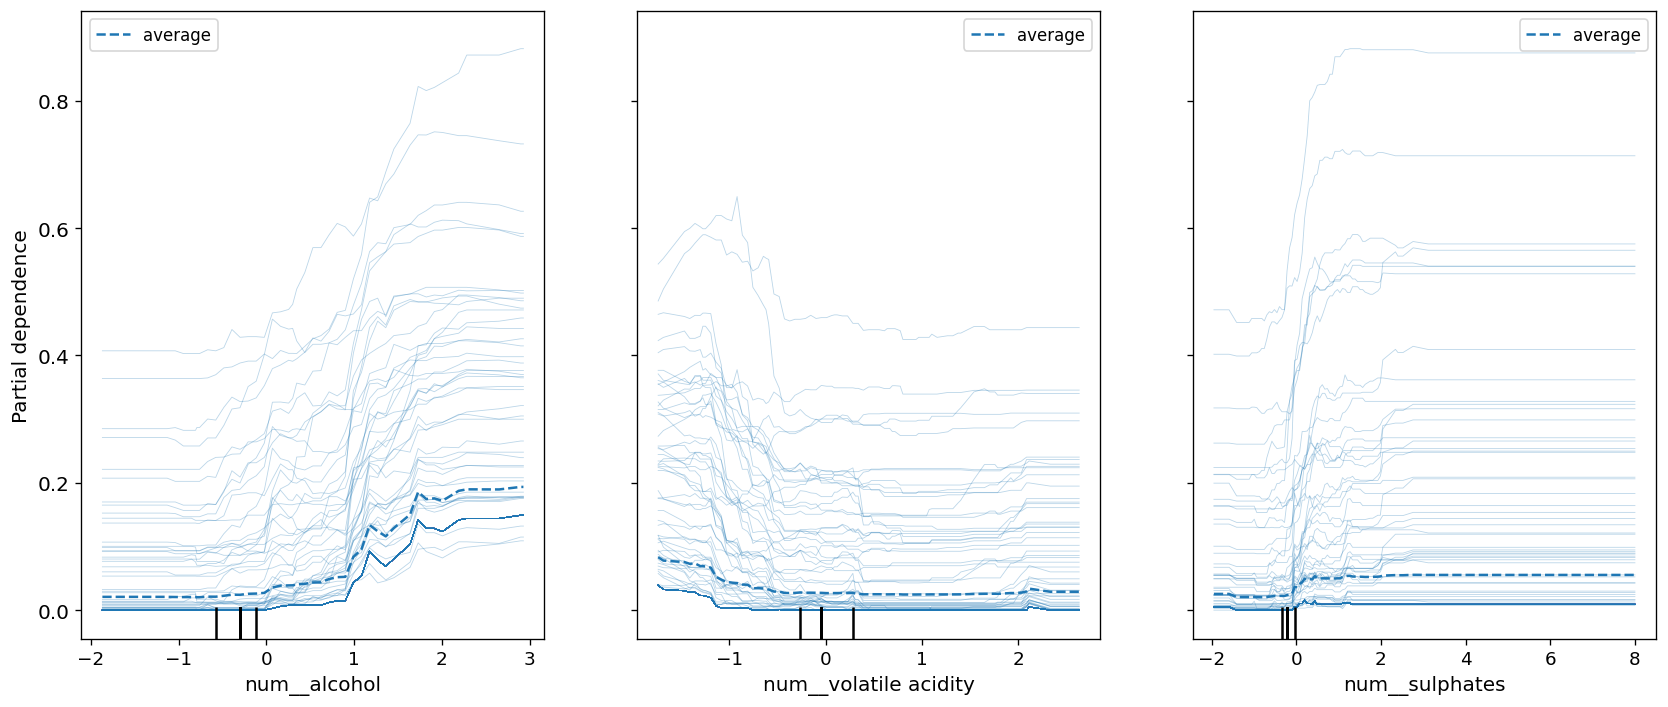


PDP for XGBoost


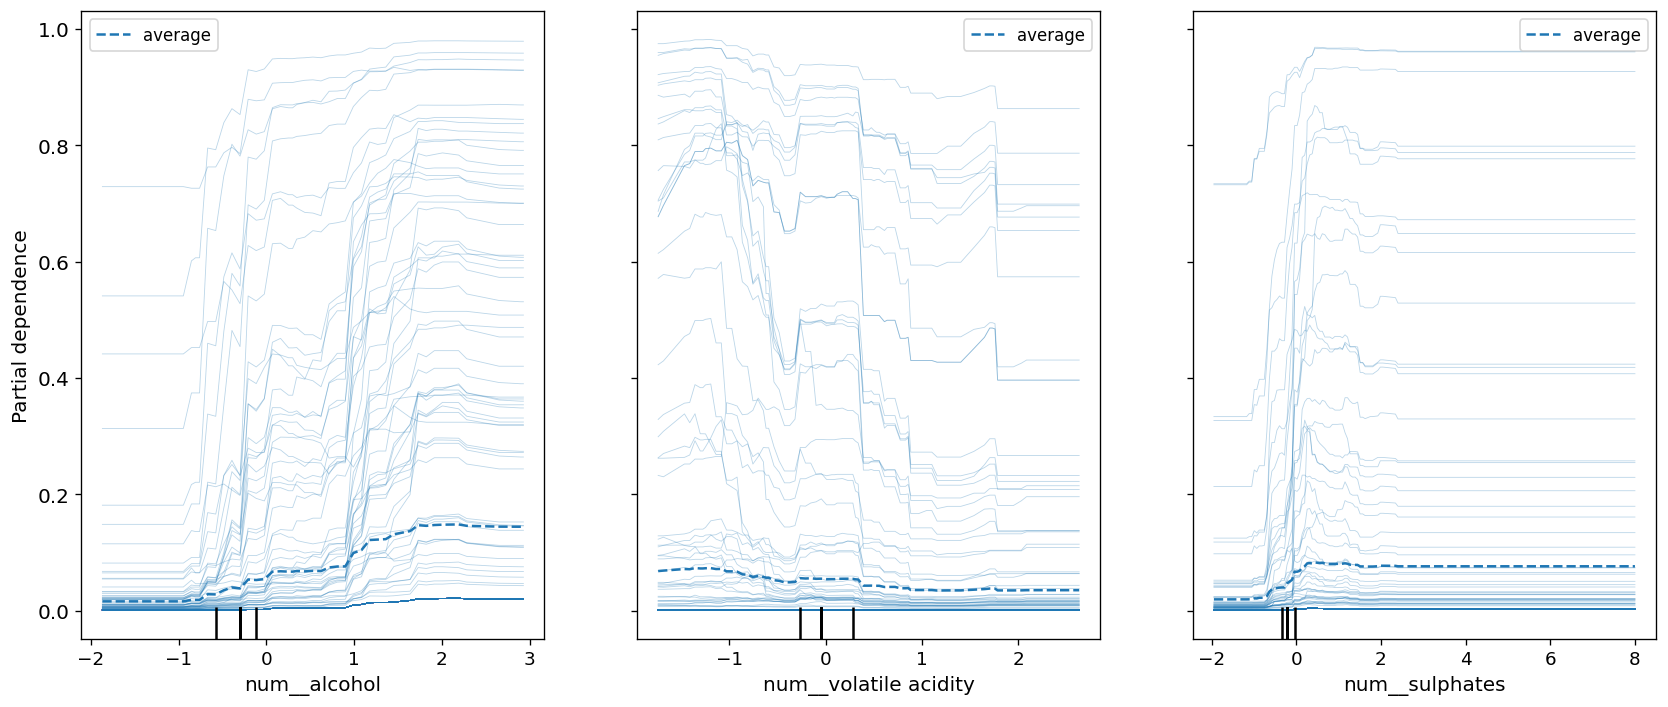

In [65]:
"""
import shap
from sklearn.inspection import PartialDependenceDisplay

# SHAP for tree-based model, in this case RandomForest and XGB
explainer_rf = shap.TreeExplainer(best_rf)
explainer_xgb = shap.TreeExplainer(best_xgb)

shap_values_rf = explainer_rf.shap_values(X_valid_imp_df)
shap_values_xgb = explainer_xgb.shap_values(X_valid_imp_df)

# Summary plots
shap.summary_plot(shap_values_rf, X_valid_imp_df, feature_names=feature_names_out, plot_size=(14,6), max_display=20, show=True)

shap.summary_plot(shap_values_xgb, X_valid_imp_df, feature_names=feature_names_out, plot_size=(14,6), max_display=20, show=True)

# PDP for key features
best_feats = ["alcohol", "volatile acidity", "sulphates"] # all numeric, then have prefix num__
features_to_plot = [f"num__{f}" for f in best_feats]

fig, ax = plt.subplots(figsize=(14, 6))
PartialDependenceDisplay.from_estimator(best_rf, X_valid_imp_df, features_to_plot, kind="both", subsample=200, ax=ax)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))
PartialDependenceDisplay.from_estimator(best_xgb, X_valid_imp_df, features_to_plot, kind="both", subsample=200, ax=ax)
plt.tight_layout()
plt.show()
"""

import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay

# Helper methods to correct shape errors for the SHAP plots

# --- helper: SHAP 2D (main effects)
def as_2d_shap(sv):
    if isinstance(sv, list):  # multiclass -> get class with greater mean absolute impact
        sv = sv[np.argmax([np.mean(np.abs(a)) for a in sv])]
    sv = np.asarray(sv)
    if sv.ndim == 3:  # interaction values -> get diagonal (main effects)
        sv = np.stack([np.diag(sv[i]) for i in range(sv.shape[0])], axis=0)
    return sv  # (n_samples, n_features)

# --- helper: align X to names/order used by model 
def align_X_to_model(X_df, model, fallback_names=None):
    if hasattr(model, "feature_names_in_"):
        names = list(model.feature_names_in_)
    elif fallback_names is not None:
        names = list(fallback_names)
    else:
        names = list(X_df.columns)
    # some features may no longer exist in X_df -> intersect in the order of the model
    names_in_X = [c for c in names if c in X_df.columns]
    X_aligned = X_df.loc[:, names_in_X]
    return X_aligned, names_in_X

# --- helper: in case of mismatch, adapt X/names/sv to same number of features
def conform_to_same_width(X_df, names, sv):
    n = min(X_df.shape[1], sv.shape[1])
    if X_df.shape[1] != sv.shape[1]:
        # message for clarity
        print(f"[MESSAGE] Adapt dimensions: X has {X_df.shape[1]} cols, SHAP has {sv.shape[1]} cols -> use the first {n}.")
    return X_df.iloc[:, :n], names[:n], sv[:, :n]

# SHAP for RF
explainer_rf = shap.TreeExplainer(best_rf)
X_rf, feat_rf = align_X_to_model(X_valid_imp_df, best_rf, fallback_names=feature_names_out)
sv_rf = as_2d_shap(explainer_rf.shap_values(X_rf))
X_rf, feat_rf, sv_rf = conform_to_same_width(X_rf, feat_rf, sv_rf)

# SHAP per XGB
explainer_xgb = shap.TreeExplainer(best_xgb)
X_xgb, feat_xgb = align_X_to_model(X_valid_imp_df, best_xgb, fallback_names=feature_names_out)
sv_xgb = as_2d_shap(explainer_xgb.shap_values(X_xgb))
X_xgb, feat_xgb, sv_xgb = conform_to_same_width(X_xgb, feat_xgb, sv_xgb)

# style
plt.rcParams.update({"figure.dpi": 120, "axes.labelsize": 12, "xtick.labelsize": 11, "ytick.labelsize": 12})

# SHAP beeswarm (main effects) large
print("\n[PLOT] SHAP plot for Random Forest")
shap.summary_plot(sv_rf,  X_rf,  feature_names=feat_rf,  plot_size=(14, 6), max_display=20, plot_type="dot", show=True)

print("\n[PLOT] SHAP plot for XGBoost")
shap.summary_plot(sv_xgb, X_xgb, feature_names=feat_xgb, plot_size=(14, 6), max_display=20, plot_type="dot", show=True)

# PDP for key features
best_feats = ["alcohol", "volatile acidity", "sulphates"] # all numeric, then have prefix num__
features_to_plot = [f"num__{f}" for f in best_feats]

fig, ax = plt.subplots(figsize=(14, 6))
print("\nPDP for Random Forest")
PartialDependenceDisplay.from_estimator(best_rf, X_valid_imp_df, features_to_plot, kind="both", subsample=200, ax=ax)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))
print("\nPDP for XGBoost")
PartialDependenceDisplay.from_estimator(best_xgb, X_valid_imp_df, features_to_plot, kind="both", subsample=200, ax=ax)
plt.tight_layout()
plt.show()

In [66]:
# Let's do some error analysis - FP and FN

import numpy as np

# Predictions with Random Forest and XGBoost - here I focus on these two
# Random Forest
y_pred_rf = best_rf.predict(X_test_imp)
y_proba_rf = best_rf.predict_proba(X_test_imp)[:,1]

# XGBoost
y_pred_xgb = best_xgb.predict(X_test_imp)
y_proba_xgb = best_xgb.predict_proba(X_test_imp)[:,1]

# Gradient Boosting
y_pred_gb = best_gb.predict(X_test_imp)
y_proba_gb = best_gb.predict_proba(X_test_imp)[:,1]

errors_df_rf = X_test.copy()
errors_df_xgb = X_test.copy()
errors_df_gb = X_test.copy()

# Random Forest
errors_df_rf["true"] = y_test.values
errors_df_rf["pred"] = y_pred_rf
errors_df_rf["proba"] = y_proba_rf

# XGBoost
errors_df_xgb["true"] = y_test.values
errors_df_xgb["pred"] = y_pred_xgb
errors_df_xgb["proba"] = y_proba_xgb

# Gradient Boost
errors_df_gb["true"] = y_test.values
errors_df_gb["pred"] = y_pred_gb
errors_df_gb["proba"] = y_proba_gb

# False positive and False negative - Random Forest
fp_rf = errors_df_rf[(errors_df_rf["true"]==0) & (errors_df_rf["pred"]==1)]
fn_rf = errors_df_rf[(errors_df_rf["true"]==1) & (errors_df_rf["pred"]==0)]

# False positive and False negative - XGBoost 
fp_xgb = errors_df_xgb[(errors_df_xgb["true"]==0) & (errors_df_xgb["pred"]==1)]
fn_xgb = errors_df_xgb[(errors_df_xgb["true"]==1) & (errors_df_xgb["pred"]==0)]

# False positive and False negative - Gradient Boosting
fp_gb = errors_df_gb[(errors_df_gb["true"]==0) & (errors_df_gb["pred"]==1)]
fn_gb = errors_df_gb[(errors_df_gb["true"]==1) & (errors_df_gb["pred"]==0)]

print("False Positives - (Random Forest):", fp_rf.shape[0])
print("False Negatives - (Random Forest):", fn_rf.shape[0])

print("False Positives - (XGBoost):", fp_xgb.shape[0])
print("False Negatives - (XGBoost):", fn_xgb.shape[0])

print("False Positives - (Gradient Boosting):", fp_gb.shape[0])
print("False Negatives - (Gradient Boosting):", fn_gb.shape[0])

# Means to try to understand a pattern
print("\nMean feature for FP - Random Forest")
display(fp_rf.mean(numeric_only=True))

print("\nMean feature for FN - Random Forest")
display(fn_rf.mean(numeric_only=True))

print("\nMean feature for FP - XGBoost")
display(fp_xgb.mean(numeric_only=True))

print("\nMean feature for FN - XGBoost")
display(fn_xgb.mean(numeric_only=True))

print("\nMean feature for FP - Gradient Boosting")
display(fp_gb.mean(numeric_only=True))

print("\nMean feature for FN - Gradient Boosting")
display(fn_gb.mean(numeric_only=True))

False Positives - (Random Forest): 5
False Negatives - (Random Forest): 13
False Positives - (XGBoost): 33
False Negatives - (XGBoost): 3
False Positives - (Gradient Boosting): 8
False Negatives - (Gradient Boosting): 7

Mean feature for FP - Random Forest


fixed acidity           10.060000
volatile acidity         0.376000
citric acid              0.512000
residual sugar           2.280000
chlorides                0.076200
free sulfur dioxide     11.000000
total sulfur dioxide    23.000000
density                  0.996072
pH                       3.196000
sulphates                0.742000
alcohol                 12.000000
true                     0.000000
pred                     1.000000
proba                    0.564551
dtype: float64


Mean feature for FN - Random Forest


fixed acidity            8.376923
volatile acidity         0.478077
citric acid              0.289231
residual sugar           2.423077
chlorides                0.073846
free sulfur dioxide     15.923077
total sulfur dioxide    28.538462
density                  0.995858
pH                       3.288462
sulphates                0.697692
alcohol                 10.992308
true                     1.000000
pred                     0.000000
proba                    0.332042
dtype: float64


Mean feature for FP - XGBoost


fixed acidity            8.787879
volatile acidity         0.390455
citric acid              0.392424
residual sugar           2.324242
chlorides                0.068000
free sulfur dioxide     13.303030
total sulfur dioxide    34.030303
density                  0.995880
pH                       3.273333
sulphates                0.695455
alcohol                 11.587879
true                     0.000000
pred                     1.000000
proba                    0.726558
dtype: float64


Mean feature for FN - XGBoost


fixed acidity            7.900000
volatile acidity         0.493333
citric acid              0.283333
residual sugar           1.733333
chlorides                0.069000
free sulfur dioxide     12.000000
total sulfur dioxide    21.666667
density                  0.994847
pH                       3.326667
sulphates                0.710000
alcohol                 10.766667
true                     1.000000
pred                     0.000000
proba                    0.311885
dtype: float64


Mean feature for FP - Gradient Boosting


fixed acidity            9.700000
volatile acidity         0.380000
citric acid              0.495000
residual sugar           2.350000
chlorides                0.074625
free sulfur dioxide     15.125000
total sulfur dioxide    29.500000
density                  0.996355
pH                       3.212500
sulphates                0.741250
alcohol                 11.950000
true                     0.000000
pred                     1.000000
proba                    0.662263
dtype: float64


Mean feature for FN - Gradient Boosting


fixed acidity            8.685714
volatile acidity         0.440000
citric acid              0.304286
residual sugar           1.971429
chlorides                0.070143
free sulfur dioxide     14.285714
total sulfur dioxide    25.000000
density                  0.995459
pH                       3.235714
sulphates                0.715714
alcohol                 10.800000
true                     1.000000
pred                     0.000000
proba                    0.097374
dtype: float64

In [67]:
import joblib
from pathlib import Path


# Save pipeline + model - Random Forest
final_pipeline_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_rf)
])

# Save pipeline + model - XGB
final_pipeline_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_xgb)
])

# Save pipeline + model - Gradient Boosting
final_pipeline_gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_gb)
])

# Output path
models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)
thresholds_dir = models_dir / "thresholds"
thresholds_dir.mkdir(parents=True, exist_ok=True)

rf_path  = models_dir / "wine_model_rf.pkl"
xgb_path = models_dir / "wine_model_xgb.pkl"
gb_path = models_dir / "wine_model_gb.pkl"
thr_path = thresholds_dir / "wine_threshold.pkl"

joblib.dump(final_pipeline_rf, rf_path)
joblib.dump(final_pipeline_xgb, xgb_path)
joblib.dump(final_pipeline_gb, gb_path)


best_threshold = 0.883 # found in Step 4 - best threshold for F1 score
joblib.dump(best_threshold, thr_path)

print(f"Random Forest saved in:  {rf_path.resolve()}")
print(f"XGB saved in: {xgb_path.resolve()}")
print(f"Gradient Boosting saved in: {gb_path.resolve()}")
print(f"Threshold saved: {thr_path.resolve()}")


Random Forest saved in:  /Users/andy.drumbeat/Desktop/CV PROJECTS/WINE SOMMELIER - GOOD VS BAD/models/wine_model_rf.pkl
XGB saved in: /Users/andy.drumbeat/Desktop/CV PROJECTS/WINE SOMMELIER - GOOD VS BAD/models/wine_model_xgb.pkl
Gradient Boosting saved in: /Users/andy.drumbeat/Desktop/CV PROJECTS/WINE SOMMELIER - GOOD VS BAD/models/wine_model_gb.pkl
Threshold saved: /Users/andy.drumbeat/Desktop/CV PROJECTS/WINE SOMMELIER - GOOD VS BAD/models/thresholds/wine_threshold.pkl
